## Problem statement :

Bank XYZ has been observing a lot of customers closing their accounts or switching to competitor banks over the past couple of quarters. As such, this has caused a huge dent in the quarterly revenues and might drastically affect annual revenues for the ongoing financial year, causing stocks to plunge and market cap to reduce by X %. A team of business, product, engineering and data science folks have been put together to arrest this slide. 

__Objective__ : Can we build a model to predict, with a reasonable accuracy, the customers who are going to churn in the near future? Being able to accurately estimate when they are going to churn will be an added bonus

__Definition of churn__ : A customer having closed all their active accounts with the bank is said to have churned. Churn can be defined in other ways as well, based on the context of the problem. A customer not transacting for 6 months or 1 year can also be defined as to have churned, based on the business requirements 

__From a Biz team/Product Manager's perspective :__  

(1) Business goal : Arrest slide in revenues or loss of active bank customers

(2) Identify data source : Transactional systems, event-based logs, Data warehouse (MySQL DBs, Redshift/AWS), Data Lakes, NoSQL DBs

(3) Audit for data quality : De-duplication of events/transactions, Complete or partial absence of data for chunks of time in between, Obscuring PII (personal identifiable information) data 

(4) Define business and data-related metrics : Tracking of these metrics over time, probably through some intuitive visualizations
    
    (i) Business metrics : Churn rate (month-on-month, weekly/quarterly), Trend of avg. number of products per customer, 
        %age of dormant customers, Other such descriptive metrics
    
    (ii) Data-related metrics : F1-score, Recall, Precision
         Recall = TP/(TP + FN) 
         Precision = TP/(TP + FP)
         F1-score = Harmonic mean of Recall and Precision
         where, TP = True Positive, FP = False Positive and FN = False Negative

(5) Prediction model output format : Since this is not going to be an online model, it doesn't require deployment. Instead, periodic (monthly/quarterly) model runs could be made and the list of customers, along with their propensity to churn shared with the business (Sales/Marketing) or Product team

(6) Action to be taken based on model's output/insights : Based on the output obtained from Data Science team as above, various business interventions can be made to save the customer from getting churned. Customer-centric bank offers, getting in touch with customers to address grievances etc. Here, also Data Science team can help with basic EDA to highlight different customer groups/segments and the appropriate intervention to be applied against them

__Collaboration with Engineering and DevOps :__  

(1) Application deployment on production servers (In the context of this problem statement, not required)

(2) [DevOps] Monitoring the scale aspects of model performance over time (Again, not required, in this case)

<img src="org_interactions.png">

### How to set the target/goal for the metrics?

* Data science-related metrics :
    - Recall : >70%
    - Precision : >70%
    - F1-score : >70%


* Business metrics : Usually, it's top down. But a good practice is to consider it to make atleast half the impact of the data science metric. For e.g., If we take Recall target as __70%__ which means correctly identifying 70% of customers who's going to churn in the near future, we can expect that due to business intervention (offers, getting in touch with customers etc.), 50% of the customers can be saved from being churned, which means atleast a __35%__ improvement in Churn Rate

## Show me the code!

In [1]:
%matplotlib inline

In [2]:
## Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
## Get multiple outputs in the same cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Ignore all warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [4]:
## Display all rows and columns of a dataframe instead of a truncated version
from IPython.display import display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
## Reading the dataset
# This might be present in S3, or obtained through a query on a database
df = pd.read_csv('Churn_Modelling.csv')

In [6]:
df.shape

(10000, 14)

In [7]:
df.head(10).T

,0,1,2,3,4,5,6,7,8,9
RowNumber,1,2,3,4,5,6,7,8,9,10
CustomerId,15634602,15647311,15619304,15701354,15737888,15574012,15592531,15656148,15792365,15592389
Surname,Hargrave,Hill,Onio,Boni,Mitchell,Chu,Bartlett,Obinna,He,H?
CreditScore,619,608,502,699,850,645,822,376,501,684
Geography,France,Spain,France,France,Spain,Spain,France,Germany,France,France
Gender,Female,Female,Female,Female,Female,Male,Male,Female,Male,Male
Age,42,41,42,39,43,44,50,29,44,27
Tenure,2,1,8,1,2,8,7,4,4,2
Balance,0,83807.9,159661,0,125511,113756,0,115047,142051,134604
NumOfProducts,1,1,3,2,1,2,2,4,2,1


### Questioning the data :

 - No date/time column. A lot of useful features can be built using date/time columns
 - When was the data snapshot taken? There are certain customer features like : Balance, Tenure, NumOfProducts, EstimatedSalary, which will have different values across time
 - Are all these values/features pertaining to the same single date or spread across multiple dates?
 - How frequently are customer features updated?
 - Will it be possible to have the values of these features over a period of time as opposed to a single, snapshot date?
 - Some customers who have exited still have balance in their account, or a non-zero NumOfProducts. Does this mean they have churned only from a specific product and not the entire bank, or are these snapshots of just before they churned?
 - Some features like, number and kind of transactions, can help us estimate the degree of activity of the customer, instead of trusting the binary variable IsActiveMember
 - Customer transaction patterns can also help us ascertain whether the customer has actually churned or not. For example, a customer might transact daily/weekly vs a customer who transacts annuallly
 
 Here, the objective is to understand the data and distill the problem statement and the stated goal further. In the process, if more data/context can be obtained, that adds to the end result of the model performance

### Basic EDA

In [8]:
df.describe() # Describe all numerical columns
df.describe(include = ['O']) #Describe all non-numerical/categorical columns

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


,Surname,Geography,Gender
count,10000,10000,10000
unique,2932,3,2
top,Smith,France,Male
freq,32,5014,5457


In [9]:
df_t = df.groupby(['Surname']).agg({'RowNumber':'count', 'Exited':'mean'}
                                  ).reset_index().sort_values(by='RowNumber', ascending=False)

In [10]:
df_t.head()

,Surname,RowNumber,Exited
2473,Smith,32,0.281250
1689,Martin,29,0.310345
2389,Scott,29,0.103448
2751,Walker,28,0.142857
336,Brown,26,0.192308


In [11]:
df.Geography.value_counts(normalize=True)

France     0.5014
Germany    0.2509
Spain      0.2477
Name: Geography, dtype: float64

In [12]:
df.shape[0], df.CustomerId.nunique()

(10000, 10000)

 - Discard row number
 - Discard CustomerID as well, since it doesn't convey any extra info. Each row pertains to a unique customer
 - Based on the above, columns/features can be segregated into non-essential, numerical, categorical and target variables
 
In general, CustomerID is a very useful feature on the basis of which we can calculate a lot of user-centric features. Here, the dataset is not sufficient to calculate any extra customer features

In [8]:
## Separating out different columns into various categories as defined above
target_var = ['Exited']
cols_to_remove = ['RowNumber', 'CustomerId']
num_feats = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
cat_feats = ['Surname', 'Geography', 'Gender', 'HasCrCard', 'IsActiveMember']

Among these, Tenure and NumOfProducts are ordinal variables. HasCrCard and IsActiveMember are actually binary categorical variables.

In [9]:
## Separating out target variable and removing the non-essential columns
y = df[target_var].values
df.drop(cols_to_remove, axis=1, inplace=True)

### Separating out train-test-valid sets

Since this is the only data available to us, we keep aside a holdout/test set to evaluate our model at the very end in order to estimate our chosen model's performance on unseen data / new data.

A validation set is also created which we'll use in our baseline models to evaluate and tune our models

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
## Keeping aside a test/holdout set
df_train_val, df_test, y_train_val, y_test = train_test_split(df, y.ravel(), test_size = 0.1, random_state = 42)

## Splitting into train and validation set
df_train, df_val, y_train, y_val = train_test_split(df_train_val, y_train_val, test_size = 0.12, random_state = 42)

In [12]:
df_train.shape, df_val.shape, df_test.shape, y_train.shape, y_val.shape, y_test.shape
np.mean(y_train), np.mean(y_val), np.mean(y_test)

((7920, 12), (1080, 12), (1000, 12), (7920,), (1080,), (1000,))

(0.20303030303030303, 0.22037037037037038, 0.191)

### Univariate plots of numerical variables in training set

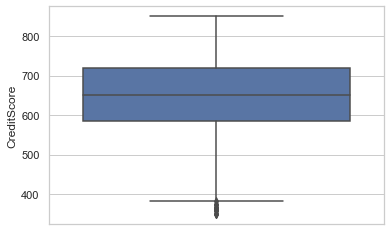

In [18]:
## CreditScore
sns.set(style="whitegrid")
sns.boxplot(y = df_train['CreditScore'])

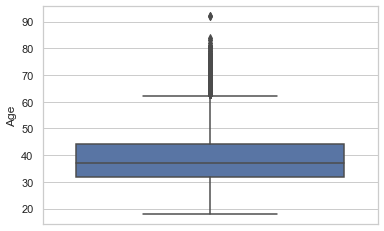

In [19]:
## Age
sns.boxplot(y = df_train['Age'])

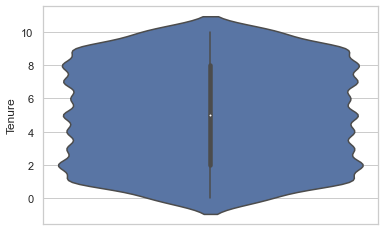

In [20]:
## Tenure
sns.violinplot(y = df_train.Tenure)

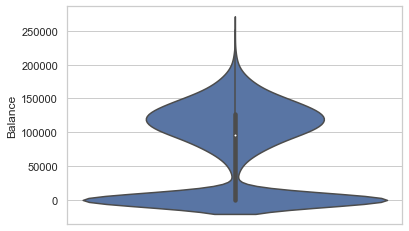

In [21]:
## Balance
sns.violinplot(y = df_train['Balance'])

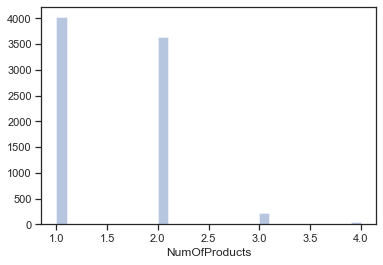

In [22]:
## NumOfProducts
sns.set(style = 'ticks')
sns.distplot(df_train.NumOfProducts, hist=True, kde=False)

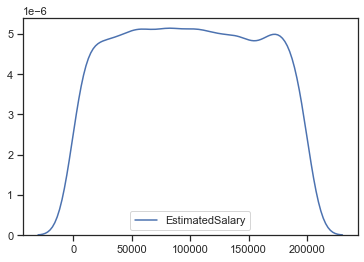

In [23]:
## EstimatedSalary
sns.kdeplot(df_train.EstimatedSalary)

 - From the univariate plots, we get an indication that _EstimatedSalary_ , being uniformly distributed, might not turn out to be an important predictor 
 - Similarly, for _NumOfProducts_ , there are predominantly only two values (1 and 2). Hence, its chances of being a strong predictor is also very unlikely
 - On the other hand, _Balance_ has a multi-modal distribution. We'll see a little later if that helps in separation of the two target classes

### Missing values and outlier treatment

No missing values / outliers present in this dataset. Easily observed from df.describe() commands. However, most real-world datasets might have missing values or outliers. A couple of things which can be done in such cases :
 - If the column/feature has too many missing values, it can be dropped as it might not add much relevance to the data
 - If there a few missing values, the column/feature can be imputed with its summary statistics (mean/median/mode) and/or numbers like 0, -1 etc. which add value depending on the data and context. For example, say, BalanceInAccount.
 - For outliers, the particular row can be removed from the training set
 - In cases where the value of outlier is logically faulty, e.g. negative Age or CreditScore > 900, the particular record can be replaced with mean of the feature or the nearest among min/max logical value of the feature 

In [125]:
## No missing values!
df_train.isnull().sum()

Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [126]:
## Making all changes in a temporary dataframe
df_missing = df_train.copy()

In [127]:
## Modify few records to add missing values/outliers

# Introducing 10% nulls in Age
na_idx = df_missing.sample(frac = 0.1).index
df_missing.loc[na_idx, 'Age'] = np.NaN

# Introducing 30% nulls in Geography
na_idx = df_missing.sample(frac = 0.3).index
df_missing.loc[na_idx, 'Geography'] = np.NaN

# Introducing 5% nulls in HasCrCard
na_idx = df_missing.sample(frac = 0.05).index
df_missing.loc[na_idx, 'HasCrCard'] = np.NaN

In [128]:
df_missing.isnull().sum()/df_missing.shape[0]

Surname            0.00
CreditScore        0.00
Geography          0.30
Gender             0.00
Age                0.10
Tenure             0.00
Balance            0.00
NumOfProducts      0.00
HasCrCard          0.05
IsActiveMember     0.00
EstimatedSalary    0.00
Exited             0.00
dtype: float64

In [129]:
## Show how missing value treatment is done

# Filling nulls in Age by mean value (numeric column)
age_mean = df_missing.Age.mean()
df_missing['Age'] = df_missing.Age.apply(lambda x: int(np.random.normal(age_mean,3)) if np.isnan(x) else x)

#df_missing.Age.fillna(age_fill_value, inplace=True)

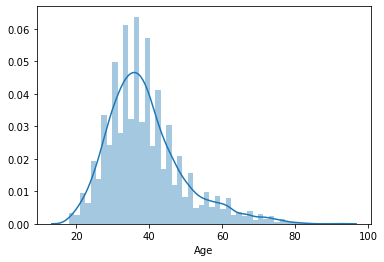

In [130]:
sns.distplot(df_train.Age)

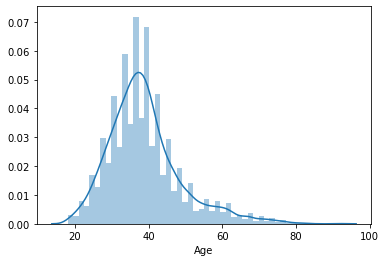

In [131]:
sns.distplot(df_missing.Age)

In [132]:
# Filling nulls in Geography (categorical feature with a high %age of missing values)
geog_fill_value = 'UNK'
df_missing.Geography.fillna(geog_fill_value, inplace=True)

# Filling nulls in HasCrCard (boolean feature) - 0 for few nulls, -1 for lots of nulls
df_missing.HasCrCard.fillna(0, inplace=True)

In [134]:
df_missing.Geography.value_counts(normalize=True)

France     0.352020
UNK        0.300000
Spain      0.174116
Germany    0.173864
Name: Geography, dtype: float64

In [135]:
df_missing.isnull().sum()/df_missing.shape[0]

Surname            0.0
CreditScore        0.0
Geography          0.0
Gender             0.0
Age                0.0
Tenure             0.0
Balance            0.0
NumOfProducts      0.0
HasCrCard          0.0
IsActiveMember     0.0
EstimatedSalary    0.0
Exited             0.0
dtype: float64

### Categorical variable encoding

* HasCrCard and IsActiveMember are already label encoded
* For Gender, a simple Label encoding should be fine.
* For Geography, since there are 3 levels, OneHotEncoding should do the trick
* For Surname, we'll try Target/Frequency Encoding

#### Label Encoding for binary variables

In [26]:
## The non-sklearn method
df_train['Gender_cat'] = df_train.Gender.astype('category').cat.codes

In [27]:
df_train.sample(10)

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Gender_cat
8539,Diggs,620,Germany,Female,25,1,137712.01,1,1,1,76197.05,0,0
8538,Crump,731,Spain,Female,33,5,137388.01,2,1,0,165000.68,0,0
4826,Panina,794,France,Male,24,10,146126.75,1,1,1,88992.05,0,1
1590,Day,632,Spain,Female,39,5,97854.37,2,1,0,93536.38,0,0
77,Read,678,France,Female,32,9,0.00,1,1,1,148210.64,0,0
501,Lueck,692,France,Male,54,5,0.00,2,1,1,88721.84,0,1
4653,Sinclair,489,France,Female,51,3,0.00,2,0,1,174098.28,1,0
2663,Bruce,542,Spain,Male,32,2,131945.94,1,0,1,159737.56,0,1
3600,Adamson,506,France,Female,57,6,0.00,2,0,1,194421.12,1,0
2954,Shoobridge,538,France,Female,33,5,0.00,2,1,0,126962.41,0,0


In [28]:
df_train.drop('Gender_cat', axis=1, inplace = True)

In [29]:
## The sklearn method
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [30]:
le = LabelEncoder()

We fit only on train dataset as that's the only data we'll assume we have. We'll treat validation and test sets as unseen data. Hence, they can't be used for fitting the encoders.

In [31]:
## Label encoding of Gender variable
df_train['Gender'] = le.fit_transform(df_train['Gender'])

In [32]:
## What if Gender column has new values in test or val set?
le.transform([['Male']])
#le.transform([['ABC']])

array([1], dtype=int64)

In [33]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
le_name_mapping

{'Female': 0, 'Male': 1}

In [34]:
pd.Series(['ABC']).map(le_name_mapping)

0   NaN
dtype: float64

In [35]:
## Encoding Gender feature for validation and test set
df_val['Gender'] = df_val.Gender.map(le_name_mapping)
df_test['Gender'] = df_test.Gender.map(le_name_mapping)

## Filling missing/NaN values created due to new categorical levels
df_val['Gender'].fillna(-1, inplace=True)
df_test['Gender'].fillna(-1, inplace=True)

In [36]:
df_train.Gender.unique(), df_val.Gender.unique(), df_test.Gender.unique()

(array([1, 0], dtype=int64),
 array([1, 0], dtype=int64),
 array([1, 0], dtype=int64))

#### One-Hot encoding for categorical variables with multiple levels

In [37]:
## The non-sklearn method
t = pd.get_dummies(df_train, prefix_sep = "_", columns = ['Geography'])
t.head()

,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
4562,Yermakova,678,1,36,1,117864.85,2,1,0,27619.06,0,0,1,0
6498,Warlow-Davies,613,0,27,5,125167.74,1,1,0,199104.52,0,1,0,0
6072,Fu,628,1,45,9,0.00,2,1,1,96862.56,0,1,0,0
5813,Shih,513,1,30,5,0.00,2,1,0,162523.66,0,1,0,0
7407,Mahmood,639,1,22,4,0.00,2,1,0,28188.96,0,1,0,0


In [38]:
### Dropping dummy column
t.drop(['Geography_France'], axis=1, inplace=True)
t.head()

,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain
4562,Yermakova,678,1,36,1,117864.85,2,1,0,27619.06,0,1,0
6498,Warlow-Davies,613,0,27,5,125167.74,1,1,0,199104.52,0,0,0
6072,Fu,628,1,45,9,0.00,2,1,1,96862.56,0,0,0
5813,Shih,513,1,30,5,0.00,2,1,0,162523.66,0,0,0
7407,Mahmood,639,1,22,4,0.00,2,1,0,28188.96,0,0,0


In [39]:
## sklearn method
le_ohe = LabelEncoder()
ohe = OneHotEncoder(handle_unknown = 'ignore', sparse=False)

In [40]:
enc_train = le_ohe.fit_transform(df_train.Geography).reshape(df_train.shape[0],1)
np.unique(enc_train)

array([0, 1, 2], dtype=int64)

In [41]:
ohe_train = ohe.fit_transform(enc_train)
ohe_train

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [42]:
le_ohe_name_mapping = dict(zip(le_ohe.classes_, le_ohe.transform(le_ohe.classes_)))
le_ohe_name_mapping

{'France': 0, 'Germany': 1, 'Spain': 2}

In [43]:
## Encoding Geography feature for validation and test set
enc_val = df_val.Geography.map(le_ohe_name_mapping).reshape(-1,1)
enc_test = df_test.Geography.map(le_ohe_name_mapping).reshape(-1,1)

## Filling missing/NaN values created due to new categorical levels
enc_val[np.isnan(enc_val)] = 9999
enc_test[np.isnan(enc_test)] = 9999

In [44]:
np.unique(enc_val)
np.unique(enc_test)

array([0, 1, 2], dtype=int64)

array([0, 1, 2], dtype=int64)

In [45]:
ohe_val = ohe.transform(enc_val)
ohe_test = ohe.transform(enc_test)

In [46]:
### Show what happens when a new value is inputted into the OHE 
ohe.transform(np.array([[9999]]))

array([[0., 0., 0.]])

#### Adding the one-hot encoded columns to the dataframe and removing the original feature

In [47]:
cols = ['country_' + str(x) for x in le_ohe_name_mapping.keys()]
cols

['country_France', 'country_Germany', 'country_Spain']

In [48]:
## Adding to the respective dataframes
df_train = pd.concat([df_train.reset_index(), pd.DataFrame(ohe_train, columns = cols)], axis = 1).drop(['index'], axis=1)
df_val = pd.concat([df_val.reset_index(), pd.DataFrame(ohe_val, columns = cols)], axis = 1).drop(['index'], axis=1)
df_test = pd.concat([df_test.reset_index(), pd.DataFrame(ohe_test, columns = cols)], axis = 1).drop(['index'], axis=1)

In [49]:
print("Training set")
df_train.head()
print("\n\nValidation set")
df_val.head()
print("\n\nTest set")
df_test.head()

Training set


,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain
0,Yermakova,678,Germany,1,36,1,117864.85,2,1,0,27619.06,0,0.0,1.0,0.0
1,Warlow-Davies,613,France,0,27,5,125167.74,1,1,0,199104.52,0,1.0,0.0,0.0
2,Fu,628,France,1,45,9,0.00,2,1,1,96862.56,0,1.0,0.0,0.0
3,Shih,513,France,1,30,5,0.00,2,1,0,162523.66,0,1.0,0.0,0.0
4,Mahmood,639,France,1,22,4,0.00,2,1,0,28188.96,0,1.0,0.0,0.0




Validation set


,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain
0,Sun,757,France,1,36,7,144852.06,1,0,0,130861.95,0,1.0,0.0,0.0
1,Russo,552,France,1,29,10,0.00,2,1,0,12186.83,0,1.0,0.0,0.0
2,Munro,619,France,0,30,7,70729.17,1,1,1,160948.87,0,1.0,0.0,0.0
3,Perkins,633,France,1,35,10,0.00,2,1,0,65675.47,0,1.0,0.0,0.0
4,Aliyeva,698,Spain,1,38,10,95010.92,1,1,1,105227.86,0,0.0,0.0,1.0




Test set


,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain
0,Anderson,596,Germany,1,32,3,96709.07,2,0,0,41788.37,0,0.0,1.0,0.0
1,Herring,623,France,1,43,1,0.00,2,1,1,146379.30,0,1.0,0.0,0.0
2,Amechi,601,Spain,0,44,4,0.00,2,1,0,58561.31,0,0.0,0.0,1.0
3,Liang,506,Germany,1,59,8,119152.10,2,1,1,170679.74,0,0.0,1.0,0.0
4,Chuang,560,Spain,0,27,7,124995.98,1,1,1,114669.79,0,0.0,0.0,1.0


In [50]:
## Drop the Geography column
df_train.drop(['Geography'], axis = 1, inplace=True)
df_val.drop(['Geography'], axis = 1, inplace=True)
df_test.drop(['Geography'], axis = 1, inplace=True)

#### Target encoding

Target encoding is generally useful when dealing with categorical variables of high cardinality (high number of levels).

As a rule of thumb, we can consider using :
 1. Label Encoding ---> Binary categorical variables and Ordinal variables
 2. One-Hot Encoding ---> Non-ordinal categorical variables with low to mid cardinality (< 5-10 levels)
 3. Target encoding ---> Categorical variables with > 10 levels

Here, we'll encode the column 'Surname' (which has 2932 different values!) with the mean of target variable for that level

In [51]:
df_train.head()

,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain
0,Yermakova,678,1,36,1,117864.85,2,1,0,27619.06,0,0.0,1.0,0.0
1,Warlow-Davies,613,0,27,5,125167.74,1,1,0,199104.52,0,1.0,0.0,0.0
2,Fu,628,1,45,9,0.00,2,1,1,96862.56,0,1.0,0.0,0.0
3,Shih,513,1,30,5,0.00,2,1,0,162523.66,0,1.0,0.0,0.0
4,Mahmood,639,1,22,4,0.00,2,1,0,28188.96,0,1.0,0.0,0.0


In [52]:
means = df_train.groupby(['Surname']).Exited.mean()
means.head()

Surname
Abazu       0.00
Abbie       0.00
Abbott      0.25
Abdullah    1.00
Abdulov     0.00
Name: Exited, dtype: float64

In [53]:
global_mean = df_train.Exited.mean()
global_mean

0.20303030303030303

In [54]:
## Creating new encoded features for surname - Target (mean) encoding
df_train['Surname_mean_churn'] = df_train.Surname.map(means)
df_train['Surname_mean_churn'].fillna(global_mean, inplace=True)

But, the problem with Target encoding is that it might cause data leakage, as we are considering feedback from the target variable while computing any summary statistic.

A solution is to use a modified version : Leave-one-out Target encoding.

In this, for a particular data point or row, the mean of the target is calculated by considering all rows in the same categorical level except itself. This mitigates data leakage and overfitting to some extent.

Mean for a category, __m<sub>c</sub> = S<sub>c</sub> / n<sub>c</sub>__    .....   (1)

What we need to find is the mean excluding a single sample. This can be expressed as : __m<sub>i</sub> = (S<sub>c</sub> - t<sub>i</sub>) / (n<sub>c</sub> - 1)__     .....   (2)

Using (1) and (2), we can get : __m<sub>i</sub> = (n<sub>c</sub>m<sub>c</sub> - t<sub>i</sub>) / (n<sub>c</sub> - 1)__

Here, _S<sub>c</sub>_ = Sum of target variable for category c

_n<sub>c</sub>_ = Number of rows in category c   

_t<sub>i</sub>_ = Target value of the row whose encoding is being calculated


In [55]:
## Calculate frequency of each category
freqs = df_train.groupby(['Surname']).size()
freqs.head()

Surname
Abazu       2
Abbie       1
Abbott      4
Abdullah    1
Abdulov     1
dtype: int64

In [56]:
## Create frequency encoding - Number of instances of each category in the data
df_train['Surname_freq'] = df_train.Surname.map(freqs)
df_train['Surname_freq'].fillna(0, inplace=True)

In [57]:
## Create Leave-one-out target encoding for Surname
df_train['Surname_enc'] = ((df_train.Surname_freq * df_train.Surname_mean_churn) - df_train.Exited)/(df_train.Surname_freq - 1)
df_train.head(10)

,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain,Surname_mean_churn,Surname_freq,Surname_enc
0,Yermakova,678,1,36,1,117864.85,2,1,0,27619.06,0,0.0,1.0,0.0,0.000000,4,0.000000
1,Warlow-Davies,613,0,27,5,125167.74,1,1,0,199104.52,0,1.0,0.0,0.0,0.000000,2,0.000000
2,Fu,628,1,45,9,0.00,2,1,1,96862.56,0,1.0,0.0,0.0,0.200000,10,0.222222
3,Shih,513,1,30,5,0.00,2,1,0,162523.66,0,1.0,0.0,0.0,0.285714,21,0.300000
4,Mahmood,639,1,22,4,0.00,2,1,0,28188.96,0,1.0,0.0,0.0,0.333333,3,0.500000
5,Miller,562,1,30,3,111099.79,2,0,0,140650.19,0,1.0,0.0,0.0,0.285714,14,0.307692
6,Padovesi,635,1,43,5,78992.75,2,0,0,153265.31,0,0.0,1.0,0.0,0.200000,10,0.222222
7,Edments,705,1,33,7,68423.89,1,1,1,64872.55,0,0.0,0.0,1.0,0.000000,1,NaN
8,Chan,694,1,42,8,133767.19,1,1,0,36405.21,0,1.0,0.0,0.0,0.000000,3,0.000000
9,Matthews,711,1,26,9,128793.63,1,1,0,19262.05,0,0.0,1.0,0.0,0.000000,4,0.000000


In [58]:
## Fill NaNs occuring due to category frequency being 1 or less
df_train['Surname_enc'].fillna((((df_train.shape[0] * global_mean) - df_train.Exited) / (df_train.shape[0] - 1)), inplace=True)
df_train.head(10)

,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain,Surname_mean_churn,Surname_freq,Surname_enc
0,Yermakova,678,1,36,1,117864.85,2,1,0,27619.06,0,0.0,1.0,0.0,0.000000,4,0.000000
1,Warlow-Davies,613,0,27,5,125167.74,1,1,0,199104.52,0,1.0,0.0,0.0,0.000000,2,0.000000
2,Fu,628,1,45,9,0.00,2,1,1,96862.56,0,1.0,0.0,0.0,0.200000,10,0.222222
3,Shih,513,1,30,5,0.00,2,1,0,162523.66,0,1.0,0.0,0.0,0.285714,21,0.300000
4,Mahmood,639,1,22,4,0.00,2,1,0,28188.96,0,1.0,0.0,0.0,0.333333,3,0.500000
5,Miller,562,1,30,3,111099.79,2,0,0,140650.19,0,1.0,0.0,0.0,0.285714,14,0.307692
6,Padovesi,635,1,43,5,78992.75,2,0,0,153265.31,0,0.0,1.0,0.0,0.200000,10,0.222222
7,Edments,705,1,33,7,68423.89,1,1,1,64872.55,0,0.0,0.0,1.0,0.000000,1,0.203056
8,Chan,694,1,42,8,133767.19,1,1,0,36405.21,0,1.0,0.0,0.0,0.000000,3,0.000000
9,Matthews,711,1,26,9,128793.63,1,1,0,19262.05,0,0.0,1.0,0.0,0.000000,4,0.000000


On validation and test set, we'll apply the normal Target encoding mapping as obtained from the training set

In [59]:
## Replacing by category means and new category levels by global mean
df_val['Surname_enc'] = df_val.Surname.map(means)
df_val['Surname_enc'].fillna(global_mean, inplace=True)

df_test['Surname_enc'] = df_test.Surname.map(means)
df_test['Surname_enc'].fillna(global_mean, inplace=True)

In [60]:
## Show that using LOO Target encoding decorrelates features
df_train[['Surname_mean_churn', 'Surname_enc', 'Exited']].corr()

,Surname_mean_churn,Surname_enc,Exited
Surname_mean_churn,1.000000,0.54823,0.562677
Surname_enc,0.548230,1.00000,-0.026440
Exited,0.562677,-0.02644,1.000000


In [61]:
### Deleting the 'Surname' and other redundant column across the three datasets
df_train.drop(['Surname_mean_churn'], axis=1, inplace=True)
df_train.drop(['Surname_freq'], axis=1, inplace=True)
df_train.drop(['Surname'], axis=1, inplace=True)
df_val.drop(['Surname'], axis=1, inplace=True)
df_test.drop(['Surname'], axis=1, inplace=True)

In [62]:
df_train.head()
df_val.head()
df_test.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain,Surname_enc
0,678,1,36,1,117864.85,2,1,0,27619.06,0,0.0,1.0,0.0,0.000000
1,613,0,27,5,125167.74,1,1,0,199104.52,0,1.0,0.0,0.0,0.000000
2,628,1,45,9,0.00,2,1,1,96862.56,0,1.0,0.0,0.0,0.222222
3,513,1,30,5,0.00,2,1,0,162523.66,0,1.0,0.0,0.0,0.300000
4,639,1,22,4,0.00,2,1,0,28188.96,0,1.0,0.0,0.0,0.500000


,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain,Surname_enc
0,757,1,36,7,144852.06,1,0,0,130861.95,0,1.0,0.0,0.0,0.111111
1,552,1,29,10,0.00,2,1,0,12186.83,0,1.0,0.0,0.0,0.200000
2,619,0,30,7,70729.17,1,1,1,160948.87,0,1.0,0.0,0.0,0.500000
3,633,1,35,10,0.00,2,1,0,65675.47,0,1.0,0.0,0.0,0.000000
4,698,1,38,10,95010.92,1,1,1,105227.86,0,0.0,0.0,1.0,1.000000


,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain,Surname_enc
0,596,1,32,3,96709.07,2,0,0,41788.37,0,0.0,1.0,0.0,0.083333
1,623,1,43,1,0.00,2,1,1,146379.30,0,1.0,0.0,0.0,0.203030
2,601,0,44,4,0.00,2,1,0,58561.31,0,0.0,0.0,1.0,0.333333
3,506,1,59,8,119152.10,2,1,1,170679.74,0,0.0,1.0,0.0,0.153846
4,560,0,27,7,124995.98,1,1,1,114669.79,0,0.0,0.0,1.0,0.230769


#### _Summarize_ : How to handle unknown categorical levels/values in unseen data in production?

 - Use LabelEncoding, OneHotEncoding on training set and then save the mapping and apply on the test set. For missing values, use 0, -1 etc.
 
 - Target/Frequency encoding : Create a mapping between each level and a statistical measure (mean, median, sum etc.) of the target from the training dataset. For the new categorical levels, impute the missing values suitably (can be 0, -1, or mean/mode/median)
 
 - Leave-one-out or Cross fold Target encoding avoid data leakage and help in generalization of the model

### Bivariate analysis

In [63]:
## Check linear correlation (rho) between individual features and the target variable
corr = df_train.corr()
corr

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain,Surname_enc
CreditScore,1.000000,0.000354,0.002099,0.005994,-0.001507,0.014110,-0.011868,0.035057,0.000358,-0.028117,-0.009481,0.003393,0.007561,-0.000739
Gender,0.000354,1.000000,-0.024446,0.010749,0.009380,-0.026795,0.007550,0.028094,-0.011007,-0.102331,0.000823,-0.018412,0.017361,0.008002
Age,0.002099,-0.024446,1.000000,-0.011384,0.027721,-0.033305,-0.019633,0.093573,-0.006827,0.288221,-0.038881,0.048764,-0.003648,-0.010844
Tenure,0.005994,0.010749,-0.011384,1.000000,-0.013081,0.018231,0.026148,-0.021263,0.010145,-0.010660,0.000021,-0.003131,0.003090,-0.006753
Balance,-0.001507,0.009380,0.027721,-0.013081,1.000000,-0.304318,-0.021464,-0.008085,0.027247,0.113377,-0.231770,0.405616,-0.136044,0.006925
NumOfProducts,0.014110,-0.026795,-0.033305,0.018231,-0.304318,1.000000,0.007202,0.014809,0.009769,-0.039200,0.002991,-0.015926,0.012388,-0.002020
HasCrCard,-0.011868,0.007550,-0.019633,0.026148,-0.021464,0.007202,1.000000,-0.006526,-0.008413,-0.013659,0.005881,0.008197,-0.014934,-0.000551
IsActiveMember,0.035057,0.028094,0.093573,-0.021263,-0.008085,0.014809,-0.006526,1.000000,-0.016446,-0.152477,0.002126,-0.020570,0.018003,0.004902
EstimatedSalary,0.000358,-0.011007,-0.006827,0.010145,0.027247,0.009769,-0.008413,-0.016446,1.000000,0.015881,-0.004512,0.010583,-0.005320,-0.009899
Exited,-0.028117,-0.102331,0.288221,-0.010660,0.113377,-0.039200,-0.013659,-0.152477,0.015881,1.000000,-0.106006,0.173492,-0.050264,-0.026440


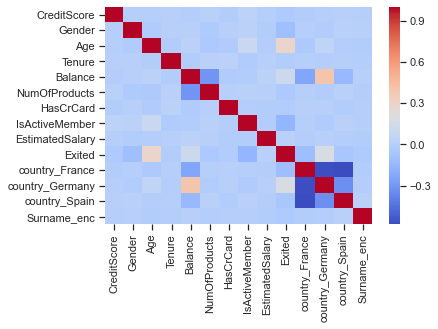

In [64]:
sns.heatmap(corr, cmap = 'coolwarm')

None of the features are highly correlated with the target variable. But some of them have slight linear associations with the target variable.

* Continuous features - Age, Balance 

* Categorical variables - Gender, IsActiveMember, country_Germany, country_France

#### Individual features versus their distibution across target variable values

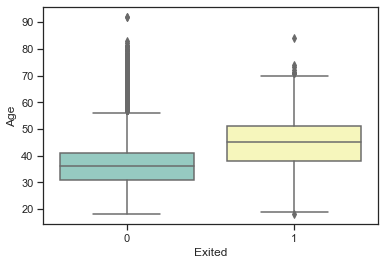

In [65]:
sns.boxplot(x = "Exited", y = "Age", data = df_train, palette="Set3")

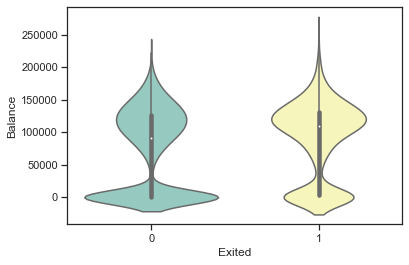

In [66]:
sns.violinplot(x = "Exited", y = "Balance", data = df_train, palette="Set3")

In [67]:
# Check association of categorical features with target variable
cat_vars_bv = ['Gender', 'IsActiveMember', 'country_Germany', 'country_France']

for col in cat_vars_bv:
    df_train.groupby([col]).Exited.mean()

Gender
0    0.248191
1    0.165511
Name: Exited, dtype: float64

IsActiveMember
0    0.266285
1    0.143557
Name: Exited, dtype: float64

country_Germany
0.0    0.163091
1.0    0.324974
Name: Exited, dtype: float64

country_France
0.0    0.245877
1.0    0.160593
Name: Exited, dtype: float64

In [68]:
col = 'NumOfProducts'
df_train.groupby([col]).Exited.mean()
df_train[col].value_counts()

NumOfProducts
1    0.273428
2    0.076881
3    0.825112
4    1.000000
Name: Exited, dtype: float64

1    4023
2    3629
3     223
4      45
Name: NumOfProducts, dtype: int64

### Some basic feature engineering

In [69]:
df_train.columns

Index(['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited',
       'country_France', 'country_Germany', 'country_Spain', 'Surname_enc'],
      dtype='object')

Creating some new features based on simple interactions between the existing features.

* Balance/NumOfProducts
* Balance/EstimatedSalary
* Tenure/Age
* Age * Surname_enc

In [70]:
eps = 1e-6

df_train['bal_per_product'] = df_train.Balance/(df_train.NumOfProducts + eps)
df_train['bal_by_est_salary'] = df_train.Balance/(df_train.EstimatedSalary + eps)
df_train['tenure_age_ratio'] = df_train.Tenure/(df_train.Age + eps)
df_train['age_surname_mean_churn'] = np.sqrt(df_train.Age) * df_train.Surname_enc

In [71]:
df_train.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain,Surname_enc,bal_per_product,bal_by_est_salary,tenure_age_ratio,age_surname_mean_churn
0,678,1,36,1,117864.85,2,1,0,27619.06,0,0.0,1.0,0.0,0.000000,58932.395534,4.267519,0.027778,0.000000
1,613,0,27,5,125167.74,1,1,0,199104.52,0,1.0,0.0,0.0,0.000000,125167.614832,0.628653,0.185185,0.000000
2,628,1,45,9,0.00,2,1,1,96862.56,0,1.0,0.0,0.0,0.222222,0.000000,0.000000,0.200000,1.490712
3,513,1,30,5,0.00,2,1,0,162523.66,0,1.0,0.0,0.0,0.300000,0.000000,0.000000,0.166667,1.643168
4,639,1,22,4,0.00,2,1,0,28188.96,0,1.0,0.0,0.0,0.500000,0.000000,0.000000,0.181818,2.345208


In [72]:
new_cols = ['bal_per_product','bal_by_est_salary','tenure_age_ratio','age_surname_mean_churn']

In [73]:
## Ensuring that the new column doesn't have any missing values
df_train[new_cols].isnull().sum()

bal_per_product           0
bal_by_est_salary         0
tenure_age_ratio          0
age_surname_mean_churn    0
dtype: int64

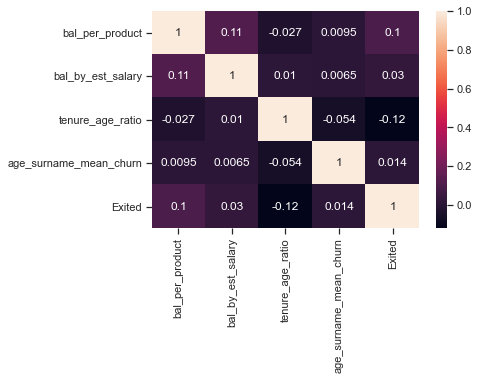

In [74]:
## Linear association of new columns with target variables to judge importance
sns.heatmap(df_train[new_cols + ['Exited']].corr(), annot=True)

Out of the new features, ones with slight linear association/correlation are : bal_per_product and tenure_age_ratio

In [75]:
## Creating new interaction feature terms for validation set
eps = 1e-6

df_val['bal_per_product'] = df_val.Balance/(df_val.NumOfProducts + eps)
df_val['bal_by_est_salary'] = df_val.Balance/(df_val.EstimatedSalary + eps)
df_val['tenure_age_ratio'] = df_val.Tenure/(df_val.Age + eps)
df_val['age_surname_mean_churn'] = np.sqrt(df_val.Age) * df_val.Surname_enc

In [76]:
## Creating new interaction feature terms for test set
eps = 1e-6

df_test['bal_per_product'] = df_test.Balance/(df_test.NumOfProducts + eps)
df_test['bal_by_est_salary'] = df_test.Balance/(df_test.EstimatedSalary + eps)
df_test['tenure_age_ratio'] = df_test.Tenure/(df_test.Age + eps)
df_test['age_surname_mean_churn'] = np.sqrt(df_test.Age) * df_test.Surname_enc

### Feature scaling and normalization

Different methods :

1. Feature transformations - Using log, log10, sqrt, pow
2. MinMaxScaler - Brings all feature values between 0 and 1
3. StandardScaler - Mean normalization. Feature values are an estimate of their z-score


* Why is scaling and normalization required ?


* How do we normalize unseen data?

#### Feature transformations

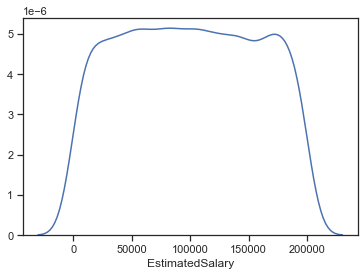

In [77]:
### Demo-ing feature transformations
sns.distplot(df_train.EstimatedSalary, hist=False)

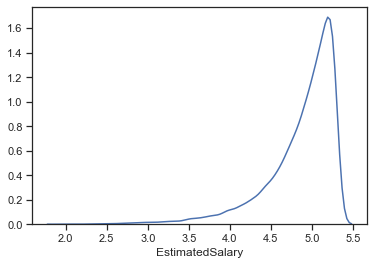

In [78]:
#sns.distplot(np.sqrt(df_train.EstimatedSalary), hist=False)
sns.distplot(np.log10(1+df_train.EstimatedSalary), hist=False)

#### StandardScaler

In [79]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

In [80]:
df_train.columns

Index(['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited',
       'country_France', 'country_Germany', 'country_Spain', 'Surname_enc',
       'bal_per_product', 'bal_by_est_salary', 'tenure_age_ratio',
       'age_surname_mean_churn'],
      dtype='object')

Scaling only continuous variables

In [81]:
cont_vars = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'Surname_enc', 'bal_per_product'
             , 'bal_by_est_salary', 'tenure_age_ratio', 'age_surname_mean_churn']
cat_vars = ['Gender', 'HasCrCard', 'IsActiveMember', 'country_France', 'country_Germany', 'country_Spain']

In [82]:
## Scaling only continuous columns
cols_to_scale = cont_vars

In [83]:
sc_X_train = sc.fit_transform(df_train[cols_to_scale])

In [84]:
## Converting from array to dataframe and naming the respective features/columns
sc_X_train = pd.DataFrame(data = sc_X_train, columns = cols_to_scale)
sc_X_train.shape
sc_X_train.head()

(7920, 11)

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Surname_enc,bal_per_product,bal_by_est_salary,tenure_age_ratio,age_surname_mean_churn
0,0.284761,-0.274383,-1.389130,0.670778,0.804059,-1.254732,-1.079210,-0.062389,0.095448,-1.232035,-1.062507
1,-0.389351,-1.128482,-0.004763,0.787860,-0.912423,1.731950,-1.079210,1.104840,-0.118834,0.525547,-1.062507
2,-0.233786,0.579716,1.379604,-1.218873,0.804059,-0.048751,0.094549,-1.100925,-0.155854,0.690966,0.193191
3,-1.426446,-0.843782,-0.004763,-1.218873,0.804059,1.094838,0.505364,-1.100925,-0.155854,0.318773,0.321611
4,-0.119706,-1.602981,-0.350855,-1.218873,0.804059,-1.244806,1.561746,-1.100925,-0.155854,0.487952,0.912973


In [85]:
## Mapping learnt on the continuous features
sc_map = {'mean':sc.mean_, 'std':np.sqrt(sc.var_)}
sc_map

{'mean': array([6.50542424e+02, 3.88912879e+01, 5.01376263e+00, 7.60258447e+04,
        1.53156566e+00, 9.96616540e+04, 2.04321788e-01, 6.24727199e+04,
        2.64665647e+00, 1.38117689e-01, 1.26136416e+00]),
 'std': array([9.64231806e+01, 1.05374237e+01, 2.88940724e+00, 6.23738902e+04,
        5.82587032e-01, 5.74167173e+04, 1.89325378e-01, 5.67456646e+04,
        1.69816787e+01, 8.95590667e-02, 1.18715858e+00])}

In [86]:
## Scaling validation and test sets by transforming the mapping obtained through the training set
sc_X_val = sc.transform(df_val[cols_to_scale])
sc_X_test = sc.transform(df_test[cols_to_scale])

In [87]:
## Converting val and test arrays to dataframes for re-usability
sc_X_val = pd.DataFrame(data = sc_X_val, columns = cols_to_scale)
sc_X_test = pd.DataFrame(data = sc_X_test, columns = cols_to_scale)

Feature scaling is important for algorithms like Logistic Regression and SVM. Not necessary for Tree-based models

### Feature selection - RFE

Features shortlisted through EDA/manual inspection and bivariate analysis :

_Age, Gender, Balance, NumOfProducts, IsActiveMember, the 3 country/Geography variables, bal per product, tenure age ratio_

Now, let's see whether feature selection/elimination through RFE (Recursive Feature Elimination) gives us the same list of features, other extra features or lesser number of features.

To begin with, we'll feed all features to RFE + LogReg model.

In [88]:
cont_vars
cat_vars

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'EstimatedSalary',
 'Surname_enc',
 'bal_per_product',
 'bal_by_est_salary',
 'tenure_age_ratio',
 'age_surname_mean_churn']

['Gender',
 'HasCrCard',
 'IsActiveMember',
 'country_France',
 'country_Germany',
 'country_Spain']

In [89]:
## Creating feature-set and target for RFE model
y = df_train['Exited'].values
X = pd.concat([df_train[cat_vars], sc_X_train[cont_vars]], ignore_index=True, axis = 1)
X.columns = cat_vars + cont_vars

In [90]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [91]:
est = LogisticRegression()
#est = SVC(kernel="linear")
num_features_to_select = 10

In [92]:
rfe = RFE(est, num_features_to_select)
rfe = rfe.fit(X.values, y)
print(rfe.support_)
print(rfe.ranking_)

[ True False  True  True  True  True False  True  True  True False False
  True False False  True False]
[1 3 1 1 1 1 2 1 1 1 6 5 1 7 4 1 8]


In [93]:
mask = rfe.support_.tolist()
selected_feats = [b for a,b in zip(mask, X.columns) if a]
selected_feats

['Gender',
 'IsActiveMember',
 'country_France',
 'country_Germany',
 'country_Spain',
 'Age',
 'Tenure',
 'Balance',
 'Surname_enc',
 'tenure_age_ratio']

#### Logit model implementation through RFE-selected features

In [94]:
import statsmodels.api as sm

In [95]:
selected_cat_vars = [x for x in selected_feats if x in cat_vars]
selected_cont_vars = [x for x in selected_feats if x in cont_vars]

In [96]:
X = pd.concat([df_train[selected_cat_vars], sc_X_train[selected_cont_vars]], ignore_index=True, axis = 1)
X.columns = selected_cat_vars + selected_cont_vars
y = df_train['Exited'].values

X.shape
y.shape

(7920, 10)

(7920,)

In [97]:
X.columns

Index(['Gender', 'IsActiveMember', 'country_France', 'country_Germany',
       'country_Spain', 'Age', 'Tenure', 'Balance', 'Surname_enc',
       'tenure_age_ratio'],
      dtype='object')

In [98]:
logit_model=sm.Logit(y,X)
result=logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.426558
         Iterations 7


In [99]:
print(result.summary2())

                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.155      
Dependent Variable: y                AIC:              6776.6844  
Date:               2020-05-01 21:56 BIC:              6846.4559  
No. Observations:   7920             Log-Likelihood:   -3378.3    
Df Model:           9                LL-Null:          -3996.2    
Df Residuals:       7910             LLR p-value:      2.2853e-260
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     7.0000                                        
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
Gender            -0.5062   0.0612  -8.2673 0.0000 -0.6263 -0.3862
IsActiveMember    -1.0591   0.0648 -16.3323 0.0000 -1.1862 -0.9320
country_France    -1.0660   0.0602 -17.6930 0.0000 -1.1841 -0.9479
country_Germany   -0.

p-values for all features are less than 0.05 (considering 95% C.I.). Hence, accepting all features and continue building models with this set of features

### Baseline model : Logistic Regression

Now let us see, which set of features give a better result - the one through RFE or the one we selected through visual EDA

In [100]:
from sklearn.linear_model import LogisticRegression

In [296]:
from sklearn.metrics import roc_auc_score, f1_score, recall_score, confusion_matrix, classification_report

In [102]:
## Using categorical features and scaled numerical features
X_train = np.concatenate((df_train[selected_cat_vars].values, sc_X_train[selected_cont_vars].values), axis = 1)
X_val = np.concatenate((df_val[selected_cat_vars].values, sc_X_val[selected_cont_vars].values), axis = 1)
X_test = np.concatenate((df_test[selected_cat_vars].values, sc_X_test[selected_cont_vars].values), axis = 1)

X_train.shape, X_val.shape, X_test.shape

((7920, 10), (1080, 10), (1000, 10))

In [103]:
# Obtaining class weights based on the class samples imbalance ratio
_, num_samples = np.unique(y_train, return_counts = True)
weights = np.max(num_samples)/num_samples
weights
num_samples

array([1.        , 3.92537313])

array([6312, 1608], dtype=int64)

In [104]:
weights_dict = {0: 1.0, 1: 2.53}

In [105]:
lr = LogisticRegression(C = 3.0, penalty = 'l1', class_weight = weights_dict, n_jobs = -1)

In [106]:
lr.fit(X_train, y_train)

LogisticRegression(C=3.0, class_weight={0: 1.0, 1: 2.53}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [107]:
X.columns

Index(['Gender', 'IsActiveMember', 'country_France', 'country_Germany',
       'country_Spain', 'Age', 'Tenure', 'Balance', 'Surname_enc',
       'tenure_age_ratio'],
      dtype='object')

In [108]:
## Fitted model parameters
lr.coef_
lr.intercept_

array([[-0.51922319, -0.95476485, -0.17874913,  0.60175287, -0.0933691 ,
         0.66852585,  0.31910408,  0.16668044, -0.06747546, -0.42321279]])

array([0.])

In [109]:
## Training metrics
roc_auc_score(y_train, lr.predict(X_train))
recall_score(y_train, lr.predict(X_train))
confusion_matrix(y_train, lr.predict(X_train))
#sns.heatmap(cm, annot=True, cmap = 'coolwarm')
print(classification_report(y_train, lr.predict(X_train)))

0.6923084198777972

0.5441542288557214

array([[5305, 1007],
       [ 733,  875]], dtype=int64)

             precision    recall  f1-score   support

          0       0.88      0.84      0.86      6312
          1       0.46      0.54      0.50      1608

avg / total       0.79      0.78      0.79      7920



In [110]:
## Validation metrics
roc_auc_score(y_val, lr.predict(X_val))
recall_score(y_val, lr.predict(X_val))
confusion_matrix(y_val, lr.predict(X_val))
#sns.heatmap(cm, annot=True, cmap = 'coolwarm')
print(classification_report(y_val, lr.predict(X_val)))

0.6654474141200423

0.5126050420168067

array([[689, 153],
       [116, 122]], dtype=int64)

             precision    recall  f1-score   support

          0       0.86      0.82      0.84       842
          1       0.44      0.51      0.48       238

avg / total       0.77      0.75      0.76      1080



#### More baseline models : Decision Tree

In [111]:
from sklearn import tree

In [112]:
weights_dict = {0: 1.0, 1: 3.2}
weights_dict

{0: 1.0, 1: 3.2}

In [113]:
## Re-defining X_train and X_val to consider original unscaled continuous features. y_train and y_val remain unaffected
X_train = df_train[selected_feats].values
X_val = df_val[selected_feats].values
X_train.shape, y_train.shape
X_val.shape, y_val.shape

((7920, 10), (7920, 1))

((1080, 10), (1080, 1))

In [114]:
clf = tree.DecisionTreeClassifier(criterion = 'gini', class_weight = weights_dict, max_depth = 3, max_features = 0.5
                                  , min_samples_split = 25, min_samples_leaf = 15)

In [115]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 1.0, 1: 3.2}, criterion='gini',
            max_depth=3, max_features=0.5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=15, min_samples_split=25,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [116]:
## Checking the importance of different features of the model
pd.DataFrame({'features': selected_feats,
              'importance': clf.feature_importances_
             }).sort_values(by = 'importance', ascending=False)

,features,importance
5,Age,0.702846
9,tenure_age_ratio,0.153417
3,country_Germany,0.069557
8,Surname_enc,0.055416
7,Balance,0.018765
0,Gender,0.000000
1,IsActiveMember,0.000000
2,country_France,0.000000
4,country_Spain,0.000000
6,Tenure,0.000000


##### Evaluating the model - Metrics

In [117]:
## Training metrics
roc_auc_score(y_train, clf.predict(X_train))
recall_score(y_train, clf.predict(X_train))
confusion_matrix(y_train, clf.predict(X_train))
#sns.heatmap(cm, annot=True, cmap = 'coolwarm')
print(classification_report(y_train, clf.predict(X_train)))

0.6993312903164784

0.638681592039801

array([[4797, 1515],
       [ 581, 1027]], dtype=int64)

             precision    recall  f1-score   support

          0       0.89      0.76      0.82      6312
          1       0.40      0.64      0.49      1608

avg / total       0.79      0.74      0.75      7920



In [118]:
## Validation metrics
roc_auc_score(y_val, clf.predict(X_val))
recall_score(y_val, clf.predict(X_val))
confusion_matrix(y_val, clf.predict(X_val))
#sns.heatmap(cm, annot=True, cmap = 'coolwarm')
print(classification_report(y_val, clf.predict(X_val)))

0.6943501866304717

0.6428571428571429

array([[628, 214],
       [ 85, 153]], dtype=int64)

             precision    recall  f1-score   support

          0       0.88      0.75      0.81       842
          1       0.42      0.64      0.51       238

avg / total       0.78      0.72      0.74      1080



#### Decision tree visualization/plot

In [119]:
from sklearn.tree import export_graphviz
import subprocess

In [120]:
## Export as dot file
dot_data = export_graphviz(clf, out_file = 'tree.dot'
                          , feature_names = selected_feats
                          , class_names = ['Did not churn', 'Churned']
                          , rounded = True, proportion = False
                          , precision = 2, filled = True)

In [121]:
## Convert to png using system command (requires Graphviz)
subprocess.run(['dot', '-Tpng','tree.dot', '-o', 'tree.png', '-Gdpi=600'])

CompletedProcess(args=['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'], returncode=0)

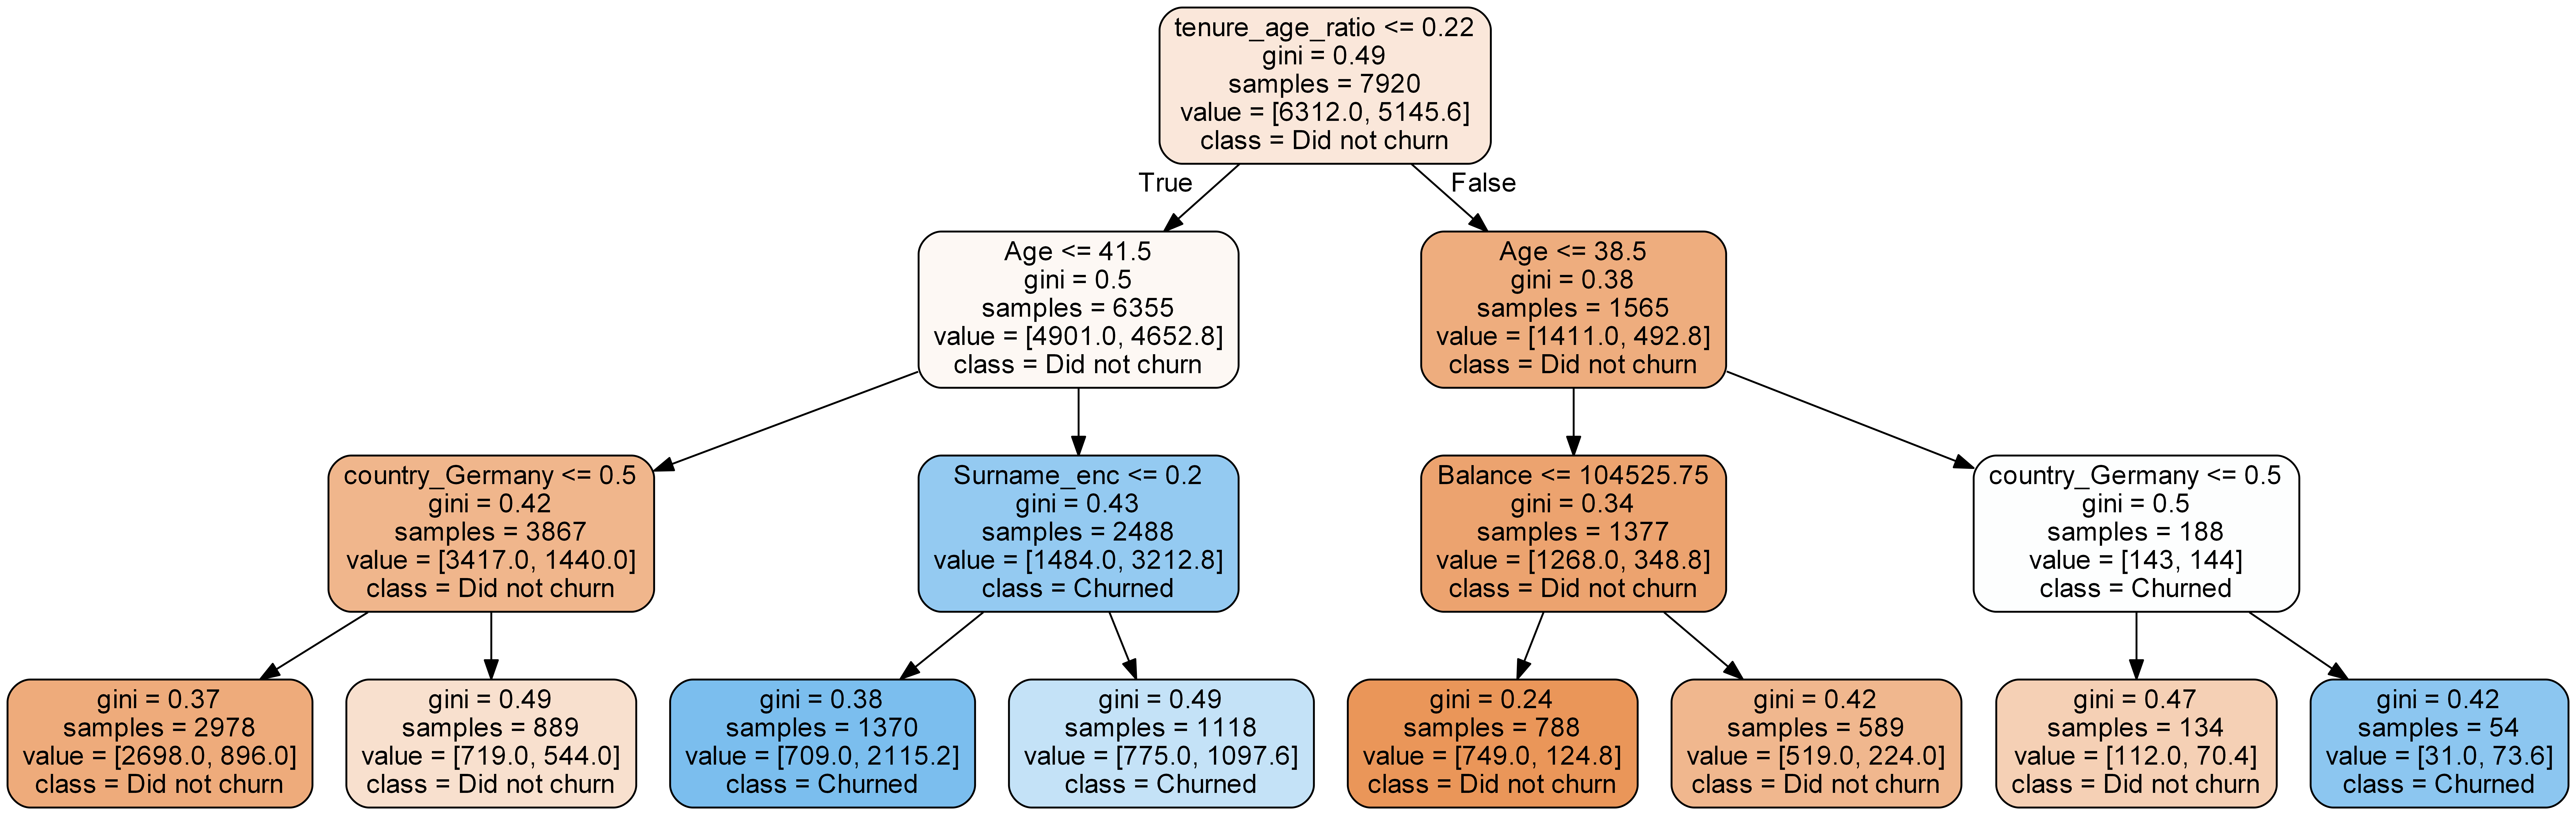

In [122]:
## Display the rule-set of a single tree
from IPython.display import Image
Image(filename = 'tree.png')

### More Tree models - RF/XGB/LGBM

#### How are models selected ?

 - Why only tree models ? Why not SVM or ANNs?

#### RF model

In [123]:
from sklearn.ensemble import RandomForestClassifier

C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [266]:
_, num_samples = np.unique(y_train, return_counts = True)
weights = np.max(num_samples)/num_samples
weights
num_samples

array([1.        , 3.92537313])

array([6312, 1608], dtype=int64)

In [267]:
weights_dict = dict()
class_labels = [0,1]
for a,b in zip(class_labels,weights):
    weights_dict[a] = b

weights_dict

{0: 1.0, 1: 3.925373134328358}

In [268]:
## Re-defining X_train and X_val to consider original unscaled continuous features. y_train and y_val remain unaffected
## Utilising all features vs selected features compared
X_train = df_train[cat_vars+cont_vars].values
X_val = df_val[cat_vars+cont_vars].values
X_train.shape, y_train.shape
X_val.shape, y_val.shape

((7920, 17), (7920, 1))

((1080, 17), (1080, 1))

In [269]:
clf = RandomForestClassifier(n_estimators = 1001, n_jobs = -1, criterion = 'entropy', class_weight = 'balanced', max_depth = 6
                             , max_features = 0.5, min_samples_split = 30, min_samples_leaf = 20)

In [270]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=6, max_features=0.5,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=20,
            min_samples_split=30, min_weight_fraction_leaf=0.0,
            n_estimators=1001, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [271]:
## Checking the importance of different features of the model
pd.DataFrame({'features': cat_vars+cont_vars,
              'importance': clf.feature_importances_
             }).sort_values(by = 'importance', ascending=False)

,features,importance
7,Age,0.364397
10,NumOfProducts,0.241808
12,Surname_enc,0.105132
2,IsActiveMember,0.061629
13,bal_per_product,0.045500
4,country_Germany,0.041877
16,age_surname_mean_churn,0.034168
9,Balance,0.032688
14,bal_by_est_salary,0.025275
15,tenure_age_ratio,0.014794


#### LightGBM classifier

In [130]:
from lightgbm import LGBMClassifier

In [195]:
## Re-defining X_train and X_val to consider original unscaled continuous features. y_train and y_val remain unaffected
## Utilising all features vs selected features compared
X_train = df_train[selected_feats].values
X_val = df_val[selected_feats].values
X_train.shape, y_train.shape
X_val.shape, y_val.shape

((7920, 10), (7920, 1))

((1080, 10), (1080, 1))

In [202]:
clf = LGBMClassifier(boosting_type='dart', num_leaves=9, max_depth= 4, learning_rate=0.1, n_estimators=101, class_weight=weights_dict
                     , min_child_samples=20, subsample=1.0, colsample_bytree=0.3, reg_alpha=0.3, reg_lambda=1.0, n_jobs=- 1
                     , importance_type = 'gain')

In [203]:
clf.fit(X_train, y_train, early_stopping_rounds = None)

LGBMClassifier(boosting_type='dart',
        class_weight={0: 1.0, 1: 3.925373134328358}, colsample_bytree=0.3,
        importance_type='gain', learning_rate=0.1, max_depth=4,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=101, n_jobs=-1, num_leaves=9, objective=None,
        random_state=None, reg_alpha=0.3, reg_lambda=1.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [204]:
## Checking the importance of different features of the model
pd.DataFrame({'features': selected_feats,
              'importance': clf.feature_importances_
             }).sort_values(by = 'importance', ascending=False)

,features,importance
5,Age,18300.254154
8,Surname_enc,17166.244853
1,IsActiveMember,3896.430218
9,tenure_age_ratio,3367.326543
3,country_Germany,3034.769725
7,Balance,2807.156753
0,Gender,1474.616369
6,Tenure,1163.501544
2,country_France,369.715782
4,country_Spain,187.446369


#### XGBoost model

Read more about XGB parameters from here  : https://xgboost.readthedocs.io/en/latest/parameter.html

In [193]:
from xgboost import XGBClassifier

In [380]:
custom_feats = cat_vars + cont_vars
exclude_cols = []
custom_feats = [i for i in custom_feats if i not in exclude_cols]
len(custom_feats)
custom_feats

17

['Gender',
 'HasCrCard',
 'IsActiveMember',
 'country_France',
 'country_Germany',
 'country_Spain',
 'CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'EstimatedSalary',
 'Surname_enc',
 'bal_per_product',
 'bal_by_est_salary',
 'tenure_age_ratio',
 'age_surname_mean_churn']

In [392]:
## Re-defining X_train and X_val to consider original unscaled continuous features. y_train and y_val remain unaffected
## Utilising all features vs selected features compared
X_train = df_train[custom_feats].values
X_val = df_val[custom_feats].values
X_train.shape, y_train.shape
X_val.shape, y_val.shape

((7920, 17), (7920, 1))

((1080, 17), (1080, 1))

In [393]:
num_samples
weight = (num_samples[0]/num_samples[1]).round(2)
weight

array([6312, 1608], dtype=int64)

3.93

In [394]:
clf = XGBClassifier(objective='binary:logistic', n_estimators = 201, max_depth = 6, learning_rate = 0.03, booster = 'gbtree'
                    , n_jobs = -1, subsample = 0.9, colsample_bytree = 0.5, reg_alpha = 0.5, reg_lambda = 0.1
                    , scale_pos_weight = weight/2)

In [395]:
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.5, gamma=0,
       learning_rate=0.03, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=201, n_jobs=-1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.5, reg_lambda=0.1, scale_pos_weight=1.965, seed=None,
       silent=None, subsample=0.9, verbosity=1)

In [396]:
## Checking the importance of different features of the model
pd.DataFrame({'features': custom_feats,
              'importance': clf.feature_importances_
             }).sort_values(by = 'importance', ascending=False)

,features,importance
10,NumOfProducts,0.256925
7,Age,0.123449
2,IsActiveMember,0.122612
12,Surname_enc,0.113539
4,country_Germany,0.076503
13,bal_per_product,0.033916
3,country_France,0.033557
0,Gender,0.033204
5,country_Spain,0.032468
9,Balance,0.032450


##### Evaluating the model - Metrics

In [397]:
## Training metrics
roc_auc_score(y_train, clf.predict(X_train))
recall_score(y_train, clf.predict(X_train))
confusion_matrix(y_train, clf.predict(X_train))
#sns.heatmap(cm, annot=True, cmap = 'coolwarm')
print(classification_report(y_train, clf.predict(X_train)))

0.8633425079923576

0.7680348258706468

array([[6051,  261],
       [ 373, 1235]], dtype=int64)

             precision    recall  f1-score   support

          0       0.94      0.96      0.95      6312
          1       0.83      0.77      0.80      1608

avg / total       0.92      0.92      0.92      7920



In [398]:
## Validation metrics
roc_auc_score(y_val, clf.predict(X_val))
recall_score(y_val, clf.predict(X_val))
confusion_matrix(y_val, clf.predict(X_val))
#sns.heatmap(cm, annot=True, cmap = 'coolwarm')
print(classification_report(y_val, clf.predict(X_val)))

0.7233228208147867

0.5084033613445378

array([[790,  52],
       [117, 121]], dtype=int64)

             precision    recall  f1-score   support

          0       0.87      0.94      0.90       842
          1       0.70      0.51      0.59       238

avg / total       0.83      0.84      0.83      1080



### Error analysis

In [282]:
df_error = df_val.copy()
df_error['y_pred'] = clf.predict(X_val)
df_error['y_pred_prob'] = clf.predict_proba(X_val)[:,1]

In [288]:
df_error.shape
df_error.sample(5)

(1080, 20)

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain,Surname_enc,bal_per_product,bal_by_est_salary,tenure_age_ratio,age_surname_mean_churn,y_pred,y_pred_prob
482,644,1,18,7,0.00,1,0,1,59645.24,1,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.388889,0.000000,0,0.281119
667,508,0,64,2,0.00,1,1,1,6076.62,0,1.0,0.0,0.0,0.203030,0.000000,0.000000,0.031250,1.624242,0,0.194534
467,667,1,71,4,137260.78,1,0,1,94433.08,1,0.0,0.0,1.0,0.500000,137260.642739,1.453524,0.056338,4.213075,0,0.218020
1028,702,1,40,3,148556.74,1,0,1,146056.29,0,1.0,0.0,0.0,0.166667,148556.591443,1.017120,0.075000,1.054093,0,0.380608
625,571,0,33,1,0.00,2,1,0,102750.70,0,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.030303,0.000000,0,0.160931


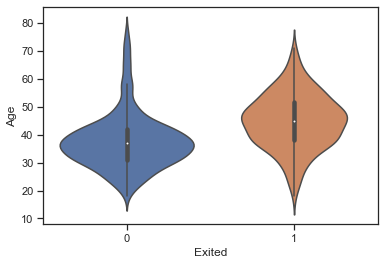

In [319]:
sns.violinplot(x = 'Exited', y = 'Age', data = df_val)

In [320]:
df_train[(df_train.Age > 42) & (df_train.Age < 53)].Exited.value_counts()
df_error[(df_error.Age > 42) & (df_error.Age < 53)].Exited.value_counts()
df_error[(df_error.Age > 42) & (df_error.Age < 53)].y_pred.value_counts()

0    842
1    610
Name: Exited, dtype: int64

0    121
1     95
Name: Exited, dtype: int64

1    137
0     79
Name: y_pred, dtype: int64

In [328]:
## Checking correlation between features and target variable vs predicted variable
x = df_error[cat_vars + cont_vars + ['y_pred', 'Exited']].corr()
x[['y_pred','Exited']]

,y_pred,Exited
Gender,-0.142768,-0.118764
HasCrCard,-0.004896,-0.006133
IsActiveMember,-0.218345,-0.176182
country_France,-0.159282,-0.083991
country_Germany,0.255284,0.163049
country_Spain,-0.077992,-0.070532
CreditScore,0.018849,-0.026118
Age,0.392884,0.290853
Tenure,-0.031719,-0.011182
Balance,0.160849,0.128656


All incorrect predictions are extracted and categorized into false positives (low precision) and false negatives (low recall)

In [287]:
low_recall = df_error[(df_error.Exited == 1) & (df_error.y_pred == 0)]
low_prec = df_error[(df_error.Exited == 0) & (df_error.y_pred == 1)]
low_recall.shape
low_prec.shape
low_recall.head()
low_prec.head()

(77, 20)

(133, 20)

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain,Surname_enc,bal_per_product,bal_by_est_salary,tenure_age_ratio,age_surname_mean_churn,y_pred,y_pred_prob
5,706,0,23,5,0.00,1,0,0,164128.41,1,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.217391,0.000000,0,0.457811
21,611,1,35,10,0.00,1,1,1,23598.23,1,1.0,0.0,0.0,0.153846,0.000000,0.000000,0.285714,0.910166,0,0.257439
92,717,0,36,2,99472.76,2,1,0,94274.72,1,1.0,0.0,0.0,0.222222,49736.355132,1.055137,0.055556,1.333333,0,0.224532
93,612,1,30,9,142910.15,1,1,0,105890.55,1,0.0,1.0,0.0,0.090909,142910.007090,1.349602,0.300000,0.497930,0,0.420091
134,757,0,30,6,161378.02,1,0,0,71926.28,1,0.0,1.0,0.0,0.000000,161377.858622,2.243659,0.200000,0.000000,0,0.492748


,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain,Surname_enc,bal_per_product,bal_by_est_salary,tenure_age_ratio,age_surname_mean_churn,y_pred,y_pred_prob
12,651,0,41,4,38617.20,1,1,1,104876.80,0,1.0,0.0,0.0,0.000000,38617.161383,0.368215,0.097561,0.000000,1,0.619190
29,787,0,38,3,158373.23,1,1,1,28228.35,0,0.0,1.0,0.0,0.333333,158373.071627,5.610432,0.078947,2.054805,1,0.567162
30,797,1,32,1,151922.94,1,1,0,8877.06,0,0.0,1.0,0.0,0.333333,151922.788077,17.114105,0.031250,1.885618,1,0.517361
44,833,0,34,3,144751.81,1,0,0,166472.81,0,1.0,0.0,0.0,0.285714,144751.665248,0.869522,0.088235,1.665986,1,0.516810
48,512,1,39,3,0.00,1,1,0,134878.19,0,0.0,0.0,1.0,0.083333,0.000000,0.000000,0.076923,0.520416,1,0.552696


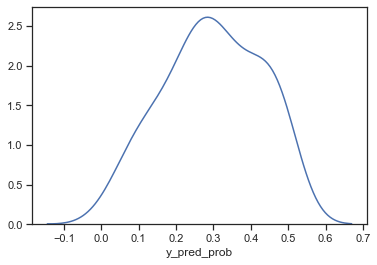

In [285]:
## Prediction probabilty distribution of errors causing low recall
sns.distplot(low_recall.y_pred_prob, hist=False)

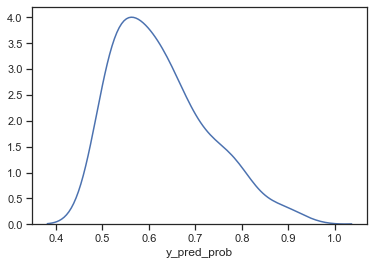

In [289]:
## Prediction probabilty distribution of errors causing low precision
sns.distplot(low_prec.y_pred_prob, hist=False)

We'll compare the top 5 important features : NumOfProducts, Surname_enc, IsActiveMember, Age and country_Germany

In [305]:
df_val.NumOfProducts.value_counts(normalize=True)
low_recall.NumOfProducts.value_counts(normalize=True)
low_prec.NumOfProducts.value_counts(normalize=True)

1    0.506481
2    0.467593
3    0.020370
4    0.005556
Name: NumOfProducts, dtype: float64

1    0.675325
2    0.324675
Name: NumOfProducts, dtype: float64

1    0.759398
2    0.218045
3    0.022556
Name: NumOfProducts, dtype: float64

In [306]:
df_val.IsActiveMember.value_counts(normalize=True)
low_recall.IsActiveMember.value_counts(normalize=True)
low_prec.IsActiveMember.value_counts(normalize=True)

1    0.518519
0    0.481481
Name: IsActiveMember, dtype: float64

0    0.571429
1    0.428571
Name: IsActiveMember, dtype: float64

0    0.631579
1    0.368421
Name: IsActiveMember, dtype: float64

In [307]:
df_val.country_Germany.value_counts(normalize=True)
low_recall.country_Germany.value_counts(normalize=True)
low_prec.country_Germany.value_counts(normalize=True)

0.0    0.732407
1.0    0.267593
Name: country_Germany, dtype: float64

0.0    0.792208
1.0    0.207792
Name: country_Germany, dtype: float64

0.0    0.601504
1.0    0.398496
Name: country_Germany, dtype: float64

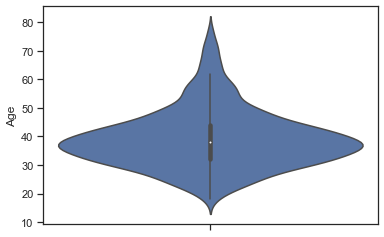

In [300]:
sns.violinplot(y = df_val.Age)

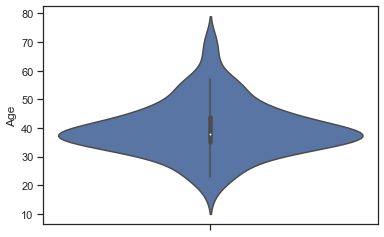

In [301]:
sns.violinplot(y = low_recall.Age)

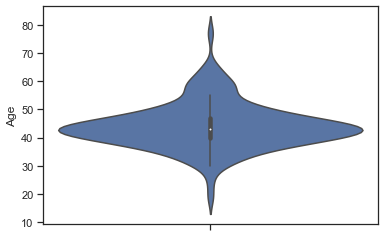

In [304]:
sns.violinplot(y = low_prec.Age)

### Automating data preparation and model run through Pipelines

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin

In [16]:
class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """ 
    Encodes categorical columns using LabelEncoding, OneHotEncoding and TargetEncoding.
    LabelEncoding is used for binary categorical columns
    OneHotEncoding is used for columns with <= 10 distinct values
    TargetEncoding is used for columns with higher cardinality (>10 distinct values)
    
    """

    def __init__(self, cols = None, lcols = None, ohecols = None, tcols = None, reduce_df = False):
        """
        
        Parameters
        ----------
        cols : list of str
            Columns to encode.  Default is to one-hot/target/label encode all categorical columns in the DataFrame.
        reduce_df : bool
            Whether to use reduced degrees of freedom for encoding
            (that is, add N-1 one-hot columns for a column with N 
            categories). E.g. for a column with categories A, B, 
            and C: When reduce_df is True, A=[1, 0], B=[0, 1],
            and C=[0, 0].  When reduce_df is False, A=[1, 0, 0], 
            B=[0, 1, 0], and C=[0, 0, 1]
            Default = False
        
        """
        
        if isinstance(cols,str):
            self.cols = [cols]
        else :
            self.cols = cols
        
        if isinstance(lcols,str):
            self.lcols = [lcols]
        else :
            self.lcols = lcols
        
        if isinstance(ohecols,str):
            self.ohecols = [ohecols]
        else :
            self.ohecols = ohecols
        
        if isinstance(tcols,str):
            self.tcols = [tcols]
        else :
            self.tcols = tcols
        
        self.reduce_df = reduce_df
    
    
    def fit(self, X, y):
        """Fit label/one-hot/target encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        
        # Encode all categorical cols by default
        if self.cols is None:
            self.cols = [c for c in X if str(X[c].dtype)=='object']

        # Check columns are in X
        for col in self.cols:
            if col not in X:
                raise ValueError('Column \''+col+'\' not in X')
        
        # Separating out lcols, ohecols and tcols
        if self.lcols is None:
            self.lcols = [c for c in self.cols if X[c].nunique() <= 2]
        
        if self.ohecols is None:
            self.ohecols = [c for c in self.cols if ((X[c].nunique() > 2) & (X[c].nunique() <= 10))]
        
        if self.tcols is None:
            self.tcols = [c for c in self.cols if X[c].nunique() > 10]
        
        
        ## Create Label Encoding mapping
        self.lmaps = dict()
        for col in self.lcols:
            self.lmaps[col] = dict(zip(X[col].values, X[col].astype('category').cat.codes.values))
        
        
        ## Create OneHot Encoding mapping
        self.ohemaps = dict() #dict to store map for each column
        for col in self.ohecols:
            self.ohemaps[col] = []
            uniques = X[col].unique()
            for unique in uniques:
                self.ohemaps[col].append(unique)
            if self.reduce_df:
                del self.ohemaps[col][-1]
        
        
        ## Create Target Encoding mapping
        self.global_target_mean = y.mean().round(2)
        self.sum_count = dict()
        for col in self.tcols:
            self.sum_count[col] = dict()
            uniques = X[col].unique()
            for unique in uniques:
                ix = X[col]==unique
                self.sum_count[col][unique] = (y[ix].sum(),ix.sum())
        
        
        ## Return the fit object
        return self
    
    
    def transform(self, X, y=None):
        """Perform label/one-hot/target encoding transformation.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to label encode
            
        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        
        Xo = X.copy()
        ## Perform label encoding transformation
        for col, lmap in self.lmaps.items():
            
            # Map the column
            Xo[col] = Xo[col].map(lmap)
            Xo[col].fillna(-1, inplace=True) ## Filling new values with -1
        
        
        ## Perform one-hot encoding transformation
        for col, vals in self.ohemaps.items():
            for val in vals:
                new_col = col+'_'+str(val)
                Xo[new_col] = (Xo[col]==val).astype('uint8')
            del Xo[col]
        
        
        ## Perform LOO target encoding transformation
        # Use normal target encoding if this is test data
        if y is None:
            for col in self.sum_count:
                vals = np.full(X.shape[0], np.nan)
                for cat, sum_count in self.sum_count[col].items():
                    vals[X[col]==cat] = (sum_count[0]/sum_count[1]).round(2)
                Xo[col] = vals
                Xo[col].fillna(self.global_target_mean, inplace=True) # Filling new values by global target mean

        # LOO target encode each column
        else:
            for col in self.sum_count:
                vals = np.full(X.shape[0], np.nan)
                for cat, sum_count in self.sum_count[col].items():
                    ix = X[col]==cat
                    vals[ix] = ((sum_count[0]-y[ix].reshape(-1,))/(sum_count[1]-1)).round(2)
                Xo[col] = vals
                Xo[col].fillna(self.global_target_mean, inplace=True) # Filling new values by global target mean
        
        
        ## Return encoded DataFrame
        return Xo
    
    
    def fit_transform(self, X, y=None):
        """Fit and transform the data via label/one-hot/target encoding.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values (required!).

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        
        return self.fit(X, y).transform(X, y)
    


In [17]:
class CustomScaler(BaseEstimator, TransformerMixin):
    """
    A custom standard scaler class with the ability to apply scaling on selected columns
    """
    
    def __init__(self, scale_cols = None):
        """
        Parameters
        ----------
        scale_cols : list of str
            Columns on which to perform scaling and normalization. Default is to scale all numerical columns
        
        """
        self.scale_cols = scale_cols
    
    
    def fit(self, X, y=None):
        """
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to scale
        """
        
        # Scaling all non-categorical columns if user doesn't provide the list of columns to scale
        if self.scale_cols is None:
            self.scale_cols = [c for c in X if str(X[c].dtype)!='object']
        
     
        ## Create mapping corresponding to scaling and normalization
        self.maps = dict()
        for col in self.scale_cols:
            self.maps[col] = dict()
            self.maps[col]['mean'] = np.mean(X[col].values).round(2)
            self.maps[col]['std_dev'] = np.std(X[col].values).round(2)
        
        # Return fit object
        return self
    
    
    def transform(self, X):
        """
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to scale
        """
        Xo = X.copy()
        
        ## Map transformation to respective columns
        for col in self.scale_cols:
            Xo[col] = (Xo[col] - self.maps[col]['mean']) / self.maps[col]['std_dev']
        
        
        # Return scaled and normalized DataFrame
        return Xo
    
    
    def fit_transform(self, X, y=None):
        """
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to scale
        """
        # Fit and return transformed dataframe
        return self.fit(X).transform(X)
    
    

In [18]:
class AddFeatures(BaseEstimator):
    """
    Add new, engineered features using original categorical and numerical features of the DataFrame
    """
    
    def __init__(self, eps = 1e-6):
        """
        Parameters
        ----------
        eps : A small value to avoid divide by zero error. Default value is 0.000001
        """
        
        self.eps = eps
    
    
    def fit(self, X, y=None):
        return self
    
    
    def transform(self, X):
        """
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing base columns using which new interaction-based features can be engineered
        """
        Xo = X.copy()
        ## Add 4 new columns - bal_per_product, bal_by_est_salary, tenure_age_ratio, age_surname_mean_churn
        Xo['bal_per_product'] = Xo.Balance/(Xo.NumOfProducts + self.eps)
        Xo['bal_by_est_salary'] = Xo.Balance/(Xo.EstimatedSalary + self.eps)
        Xo['tenure_age_ratio'] = Xo.Tenure/(Xo.Age + self.eps)
        Xo['age_surname_enc'] = np.sqrt(Xo.Age) * Xo.Surname
        
        ## Returning the updated dataframe
        return Xo
    
    
    def fit_transform(self, X, y=None):
        """
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing base columns using which new interaction-based features can be engineered
        """
        return self.fit(X,y).transform(X)
    
    

#### Testing each of the pre-processing steps in sequence

In [259]:
X = df_train.drop(columns = ['Exited'], axis = 1)
X_test = df_test.drop(columns = ['Exited'], axis = 1)

ce = CategoricalEncoder()
af = AddFeatures()
cols_to_scale = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'bal_per_product', 'bal_by_est_salary', 'tenure_age_ratio'
                ,'age_surname_enc']
cs = CustomScaler(cols_to_scale)

In [260]:
%%timeit
X0 = ce.fit_transform(X, y_train)
X0_test = ce.transform(X_test)

24.6 s ± 1.65 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [261]:
%%timeit
X1 = af.fit_transform(X0, y_train)
X1_test = af.transform(X0_test)

18.3 ms ± 4.33 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [272]:
X2 = cs.fit_transform(X1)
X2_test = cs.transform(X1_test)

In [274]:
X.head()
X0.head()
X1.head()
X2.head()

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
4562,Yermakova,678,Germany,Male,36,1,117864.85,2,1,0,27619.06
6498,Warlow-Davies,613,France,Female,27,5,125167.74,1,1,0,199104.52
6072,Fu,628,France,Male,45,9,0.00,2,1,1,96862.56
5813,Shih,513,France,Male,30,5,0.00,2,1,0,162523.66
7407,Mahmood,639,France,Male,22,4,0.00,2,1,0,28188.96


,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_France,Geography_Spain
4562,0.00,678,1,36,1,117864.85,2,1,0,27619.06,1,0,0
6498,0.00,613,0,27,5,125167.74,1,1,0,199104.52,0,1,0
6072,0.22,628,1,45,9,0.00,2,1,1,96862.56,0,1,0
5813,0.30,513,1,30,5,0.00,2,1,0,162523.66,0,1,0
7407,0.50,639,1,22,4,0.00,2,1,0,28188.96,0,1,0


,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_France,Geography_Spain,bal_per_product,bal_by_est_salary,tenure_age_ratio,age_surname_enc
4562,0.00,678,1,36,1,117864.85,2,1,0,27619.06,1,0,0,58932.395534,4.267519,0.027778,0.000000
6498,0.00,613,0,27,5,125167.74,1,1,0,199104.52,0,1,0,125167.614832,0.628653,0.185185,0.000000
6072,0.22,628,1,45,9,0.00,2,1,1,96862.56,0,1,0,0.000000,0.000000,0.200000,1.475805
5813,0.30,513,1,30,5,0.00,2,1,0,162523.66,0,1,0,0.000000,0.000000,0.166667,1.643168
7407,0.50,639,1,22,4,0.00,2,1,0,28188.96,0,1,0,0.000000,0.000000,0.181818,2.345208


,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_France,Geography_Spain,bal_per_product,bal_by_est_salary,tenure_age_ratio,age_surname_enc
4562,0.00,0.284796,1,-0.274194,1,0.670778,2,1,0,-1.254732,1,0,0,-0.062389,0.095260,-1.246914,-1.058824
6498,0.00,-0.389338,0,-1.128083,5,0.787860,1,1,0,1.731950,0,1,0,1.104840,-0.119043,0.502058,-1.058824
6072,0.22,-0.233769,1,0.579696,9,-1.218873,2,1,1,-0.048750,0,1,0,-1.100925,-0.156066,0.666667,0.181349
5813,0.30,-1.426468,1,-0.843454,5,-1.218873,2,1,0,1.094838,0,1,0,-1.100925,-0.156066,0.296296,0.321990
7407,0.50,-0.119685,1,-1.602467,4,-1.218873,2,1,0,-1.244806,0,1,0,-1.100925,-0.156066,0.464646,0.911939


In [275]:
X_test.head()
X0_test.head()
X1_test.head()
X2_test.head()

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
6252,Anderson,596,Germany,Male,32,3,96709.07,2,0,0,41788.37
4684,Herring,623,France,Male,43,1,0.00,2,1,1,146379.30
1731,Amechi,601,Spain,Female,44,4,0.00,2,1,0,58561.31
4742,Liang,506,Germany,Male,59,8,119152.10,2,1,1,170679.74
4521,Chuang,560,Spain,Female,27,7,124995.98,1,1,1,114669.79


,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_France,Geography_Spain
6252,0.08,596,1,32,3,96709.07,2,0,0,41788.37,1,0,0
4684,0.20,623,1,43,1,0.00,2,1,1,146379.30,0,1,0
1731,0.33,601,0,44,4,0.00,2,1,0,58561.31,0,0,1
4742,0.15,506,1,59,8,119152.10,2,1,1,170679.74,1,0,0
4521,0.23,560,0,27,7,124995.98,1,1,1,114669.79,0,0,1


,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_France,Geography_Spain,bal_per_product,bal_by_est_salary,tenure_age_ratio,age_surname_enc
6252,0.08,596,1,32,3,96709.07,2,0,0,41788.37,1,0,0,48354.510823,2.314258,0.093750,0.452548
4684,0.20,623,1,43,1,0.00,2,1,1,146379.30,0,1,0,0.000000,0.000000,0.023256,1.311488
1731,0.33,601,0,44,4,0.00,2,1,0,58561.31,0,0,1,0.000000,0.000000,0.090909,2.188972
4742,0.15,506,1,59,8,119152.10,2,1,1,170679.74,1,0,0,59576.020212,0.698103,0.135593,1.152172
4521,0.23,560,0,27,7,124995.98,1,1,1,114669.79,0,0,1,124995.855004,1.090052,0.259259,1.195115


,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_France,Geography_Spain,bal_per_product,bal_by_est_salary,tenure_age_ratio,age_surname_enc
6252,0.08,-0.565650,1,-0.653700,3,0.331601,2,0,0,-1.007952,1,0,0,-0.248798,-0.019773,-0.513889,-0.678531
4684,0.20,-0.285625,1,0.389943,1,-1.218873,2,1,1,0.813659,0,1,0,-1.100925,-0.156066,-1.297158,0.043267
1731,0.33,-0.513794,0,0.484820,4,-1.218873,2,1,0,-0.715825,0,0,1,-1.100925,-0.156066,-0.545455,0.780649
4742,0.15,-1.499067,1,1.907970,8,0.691415,2,1,1,1.236889,1,0,0,-0.051047,-0.114953,-0.048964,-0.090612
4521,0.23,-0.939017,0,-1.128083,7,0.785106,1,1,1,0.261390,0,0,1,1.101814,-0.091870,1.325103,-0.054525


#### Pipeline in action for a single model

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [342]:
X = df_train.drop(columns = ['Exited'], axis = 1)
X_val = df_val.drop(columns = ['Exited'], axis = 1)
X_test = df_test.drop(columns = ['Exited'], axis = 1)

cols_to_scale = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'bal_per_product', 'bal_by_est_salary', 'tenure_age_ratio'
                ,'age_surname_enc']

In [343]:
weights_dict = {0 : 1.0, 1 : 3.2}
clf = DecisionTreeClassifier(criterion = 'gini', class_weight = weights_dict, max_depth = 3, max_features = 0.5
                             , min_samples_split = 25, min_samples_leaf = 15)
rf = RandomForestClassifier(n_estimators = 1001, n_jobs = -1, criterion = 'entropy', class_weight = 'balanced', max_depth = 6
                             , max_features = 0.5, min_samples_split = 30, min_samples_leaf = 20)

In [350]:
model = Pipeline(steps = [('categorical_encoding', CategoricalEncoder()),
                          ('add_new_features', AddFeatures()),
                          ('standard_scaling', CustomScaler(cols_to_scale)),
                          ('classifier', rf)
                         ])

In [351]:
# Fit pipeline with training data
model.fit(X,y_train)

Pipeline(memory=None,
     steps=[('categorical_encoding', CategoricalEncoder(cols=['Surname', 'Geography', 'Gender'], lcols=['Gender'],
          ohecols=['Geography'], reduce_df=False, tcols=['Surname'])), ('add_new_features', AddFeatures(eps=1e-06)), ('decision_tree', RandomForestClassifier(bootstrap=True, class_weight='ba...tors=1001, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False))])

In [352]:
# Predict target values on val data
val_preds = model.predict(X_val)

In [353]:
# Predict target probabilities
val_probs = model.predict_proba(X_val)[:,1]

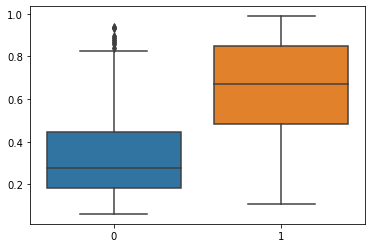

In [354]:
sns.boxplot(y_val.reshape(-1,), val_probs)

In [355]:
## Validation metrics
roc_auc_score(y_val, val_preds)
recall_score(y_val, val_preds)
confusion_matrix(y_val, val_preds)
#sns.heatmap(cm, annot=True, cmap = 'coolwarm')
print(classification_report(y_val, val_preds))

0.7618565240823171

0.7184873949579832

array([[678, 164],
       [ 67, 171]], dtype=int64)

             precision    recall  f1-score   support

          0       0.91      0.81      0.85       842
          1       0.51      0.72      0.60       238

avg / total       0.82      0.79      0.80      1080



### k-fold Cross Validation

In [332]:
from sklearn.model_selection import cross_val_score

In [338]:
X = df_train.drop(columns = ['Exited'], axis = 1)
y = y_train.ravel()

cols_to_scale = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'bal_per_product', 'bal_by_est_salary', 'tenure_age_ratio'
                ,'age_surname_enc']

weights_dict = {0 : 1.0, 1 : 3.2}
clf = DecisionTreeClassifier(criterion = 'gini', class_weight = weights_dict, max_depth = 3, max_features = 0.5
                             , min_samples_split = 25, min_samples_leaf = 15)
rf = RandomForestClassifier(n_estimators = 1001, n_jobs = -1, criterion = 'entropy', class_weight = 'balanced', max_depth = 6
                             , max_features = 0.5, min_samples_split = 30, min_samples_leaf = 20)

In [339]:
model = Pipeline(steps = [('categorical_encoding', CategoricalEncoder()),
                          ('add_new_features', AddFeatures()),
                          ('standard_scaling', CustomScaler(cols_to_scale)),
                          ('classifier', rf)
                         ])

In [340]:
# KFold/StratifiedKFold cross validation with 5 folds
# applying the classifier pipeline to the feature and target data
scores = cross_val_score(model, X, y, cv=5, scoring = 'recall')

In [341]:
scores
scores.mean()
scores.std()

array([0.71118012, 0.73602484, 0.74223602, 0.76635514, 0.71962617])

0.735084460440007

0.019184685017151686

### Hyperparameter tuning

RandomSearchCV vs GridSearchCV

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier

In [99]:
## Re-defining X_train and X_val to consider original unscaled continuous features. y_train and y_val remain unaffected
X_train = df_train.drop(columns = ['Exited'], axis = 1)
X_val = df_val.drop(columns = ['Exited'], axis = 1)


cols_to_scale = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'bal_per_product', 'bal_by_est_salary', 'tenure_age_ratio'
                ,'age_surname_enc']

X_train.shape, y_train.shape
X_val.shape, y_val.shape

((7920, 11), (7920,))

((1080, 11), (1080,))

In [100]:
_, num_samples = np.unique(y_train, return_counts = True)
weights = np.max(num_samples)/num_samples
weight = weights[1].round(2)

In [101]:
xgb = XGBClassifier(objective='binary:logistic', booster = 'gbtree', n_jobs = -1, subsample = 0.9)

In [102]:
model = Pipeline(steps = [('categorical_encoding', CategoricalEncoder()),
                          ('add_new_features', AddFeatures()),
                          ('standard_scaling', CustomScaler(cols_to_scale)),
                          ('classifier', xgb)
                         ])

#### Randomized Search

In [400]:
## Exhaustive list of parameters
parameters = {'classifier__n_estimators':[20, 51, 100, 201, 301, 350, 500, 1001]
             ,'classifier__max_depth': [3, 4, 6, 9]
             ,'classifier__learning_rate': [0.01, 0.03, 0.05, 0.1, 0.5]
             ,'classifier__colsample_bytree': [0.2, 0.3, 0.5]
             ,'classifier__reg_alpha': [0, 0.5, 1, 3, 5]
             ,'classifier__reg_lambda': [0.1, 0.5, 1, 5, 10]
             ,'classifier__scale_pos_weight': [1, weight, weight/2]}

In [33]:
search = RandomizedSearchCV(model, parameters, n_iter = 20, cv = 5, scoring = 'recall')

In [ ]:
search.fit(X_train, y_train.ravel())

In [403]:
search.best_params_
search.best_score_

{'classifier__scale_pos_weight': 3.93,
 'classifier__reg_lambda': 10,
 'classifier__reg_alpha': 5,
 'classifier__n_estimators': 20,
 'classifier__max_depth': 6,
 'classifier__learning_rate': 0.1,
 'classifier__colsample_bytree': 0.5}

0.7549774229299828

In [404]:
search.cv_results_

{'mean_fit_time': array([21.43350134, 16.18140287, 22.49190559, 16.53327036, 17.70568948,
        16.03288522, 15.30708494, 15.54205036, 17.26288204, 15.72408972,
        18.48861232, 15.71955938, 18.3143116 , 18.49905286, 18.3656601 ,
        15.88762555, 15.96763825, 18.65887494, 18.35971999, 17.27638135]),
 'std_fit_time': array([3.29676647, 1.19609245, 0.4887588 , 0.4682977 , 0.77781272,
        0.76909866, 1.08379213, 0.75471689, 1.286922  , 0.8455654 ,
        0.89239261, 0.60627005, 1.22555852, 0.9132096 , 0.48149245,
        1.68522992, 0.94195088, 0.48798064, 0.54567318, 0.49101375]),
 'mean_score_time': array([3.92555838, 3.61892662, 3.21440616, 3.45978522, 3.63548179,
        3.21780362, 3.26628189, 3.24166589, 3.47364149, 3.46734967,
        3.49289742, 3.30038562, 3.70988765, 3.51800566, 3.12664676,
        3.4173399 , 3.49924498, 3.33034029, 3.75217333, 3.50837693]),
 'std_score_time': array([0.74264525, 0.58721553, 0.33928082, 0.41759336, 0.41907243,
        0.13973443, 

#### Grid Search

In [119]:
## Current list of parameters
parameters = {'classifier__n_estimators':[750, 1001]
             ,'classifier__max_depth': [6, 9, 12]
             ,'classifier__learning_rate': [0.01]
             ,'classifier__colsample_bytree': [0.5]
             ,'classifier__reg_alpha': [0.1, 1, 5, 10]
             ,'classifier__reg_lambda': [0.1, 1, 10]
             ,'classifier__scale_pos_weight': [0.75*weight]}

In [120]:
grid = GridSearchCV(model, parameters, cv = 5, scoring = 'f1')

In [121]:
grid.fit(X_train, y_train.ravel())

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('categorical_encoding',
                                        CategoricalEncoder(cols=None,
                                                           lcols=None,
                                                           ohecols=None,
                                                           reduce_df=False,
                                                           tcols=None)),
                                       ('add_new_features',
                                        AddFeatures(eps=1e-06)),
                                       ('standard_scaling',
                                        CustomScaler(scale_cols=['CreditScore',
                                                                 'Age',
                                                                 'Balance',
                                                                 'EstimatedSala

In [123]:
grid.best_params_
grid.best_score_

{'classifier__colsample_bytree': 0.5,
 'classifier__learning_rate': 0.01,
 'classifier__max_depth': 9,
 'classifier__n_estimators': 750,
 'classifier__reg_alpha': 5,
 'classifier__reg_lambda': 1,
 'classifier__scale_pos_weight': 2.9475000000000002}

0.6321638247596203

In [124]:
grid.cv_results_

{'mean_fit_time': array([ 24.05205622,  26.35016422,  32.31774664,  33.44494424,
         32.42290845,  33.78082275,  31.24850769,  28.96529927,
         20.35000701,  19.57083106,  20.78231268,  20.85981245,
         23.10612903,  22.75003195,  22.36387706,  21.87063613,
         22.39913712,  22.79899316,  22.51549926,  22.99185877,
         22.59329453,  22.59323549,  22.37832298,  22.31403403,
         24.57697434,  25.28435745, 423.41501369,  14.2633215 ,
         26.33299351,  25.67973065,  27.23379135,  25.87914729,
         28.38007503,  26.75570784,  23.92816892,  25.77645092,
         32.48341565,  34.05819912,  32.9065475 ,  35.16305122,
         33.5434947 ,  35.55920997,  28.5548923 ,  31.44673986,
         26.3310339 ,  30.53860693,  28.97077446,  31.35448465,
         30.4058001 ,  29.55610709,  27.65406384,  26.99618216,
         33.88706408,  35.46940775,  32.55177269,  31.96830845,
         28.47428942,  30.94663844,  28.943541  ,  27.38708744,
         33.78590393,  

### Train final, best model ; Save model and its parameters

In [21]:
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, f1_score, recall_score, confusion_matrix, classification_report
import joblib

In [126]:
## Re-defining X_train and X_val to consider original unscaled continuous features. y_train and y_val remain unaffected
X_train = df_train.drop(columns = ['Exited'], axis = 1)
X_val = df_val.drop(columns = ['Exited'], axis = 1)


cols_to_scale = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'bal_per_product', 'bal_by_est_salary', 'tenure_age_ratio'
                ,'age_surname_enc']

X_train.shape, y_train.shape
X_val.shape, y_val.shape

((7920, 11), (7920,))

((1080, 11), (1080,))

In [39]:
best_recall_xgb = XGBClassifier(objective='binary:logistic', booster = 'gbtree', n_jobs = -1, subsample = 0.9, colsample_bytree = 0.5
                          , learning_rate = 0.01, max_depth = 4, n_estimators = 20, reg_alpha = 5, reg_lambda = 10
                          , scale_pos_weight = 3.93)

In [127]:
best_f1_xgb = XGBClassifier(objective='binary:logistic', booster = 'gbtree', n_jobs = -1, subsample = 0.9, colsample_bytree = 0.5
                          , learning_rate = 0.01, max_depth = 9, n_estimators = 750, reg_alpha = 5, reg_lambda = 1
                          , scale_pos_weight = 2.95)

In [128]:
model = Pipeline(steps = [('categorical_encoding', CategoricalEncoder()),
                          ('add_new_features', AddFeatures()),
                          ('standard_scaling', CustomScaler(cols_to_scale)),
                          ('classifier', best_f1_xgb)
                         ])

In [129]:
## Fitting final model on train dataset
model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('categorical_encoding',
                 CategoricalEncoder(cols=['Surname', 'Geography', 'Gender'],
                                    lcols=['Gender'], ohecols=['Geography'],
                                    reduce_df=False, tcols=['Surname'])),
                ('add_new_features', AddFeatures(eps=1e-06)),
                ('standard_scaling',
                 CustomScaler(scale_cols=['CreditScore', 'Age', 'Balance',
                                          'EstimatedSalary', 'bal_per_product',
                                          'bal_by_est...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.5, gamma=0,
                               learning_rate=0.01, max_delta_step=0,
                               max_depth=9, min_child_weight=1, missing=None,
                               n_estimators=750, n_j

In [130]:
# Predict target values on val data
val_preds = model.predict(X_val)

In [131]:
# Predict target probabilities
val_probs = model.predict_proba(X_val)[:,1]

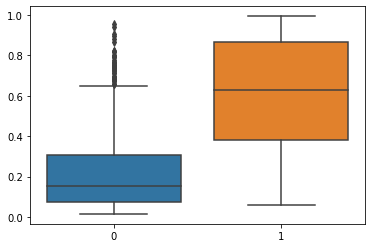

In [132]:
sns.boxplot(y_val.ravel(), val_probs)

In [133]:
## Validation metrics
roc_auc_score(y_val, val_preds)
recall_score(y_val, val_preds)
confusion_matrix(y_val, val_preds)
#sns.heatmap(cm, annot=True, cmap = 'coolwarm')
print(classification_report(y_val, val_preds))

0.7676201121778877

0.6302521008403361

array([[762,  80],
       [ 88, 150]], dtype=int64)

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       842
           1       0.65      0.63      0.64       238

    accuracy                           0.84      1080
   macro avg       0.77      0.77      0.77      1080
weighted avg       0.84      0.84      0.84      1080



In [134]:
## Save model object
joblib.dump(model, 'final_churn_model_f1.sav')

['final_churn_model_f1.sav']

### Load saved model and make predictions on unseen/future data

Here, we'll use df_test as the unseen, future data

In [13]:
import joblib

In [22]:
## Save model object
model = joblib.load('final_churn_model_f1.sav')

In [24]:
X_test = df_test.drop(columns = ['Exited'], axis = 1)
X_test.shape
y_test.shape

cols_to_scale = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'bal_per_product', 'bal_by_est_salary', 'tenure_age_ratio'
                ,'age_surname_enc']

(1000, 11)

(1000,)

In [25]:
# Predict target values on test data
test_preds = model.predict(X_test)

In [26]:
# Predict target probabilities
test_probs = model.predict_proba(X_test)[:,1]

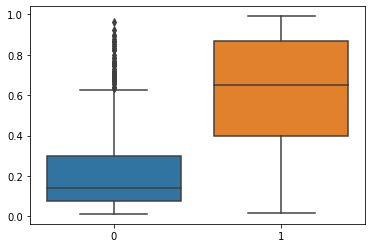

In [27]:
sns.boxplot(y_test.ravel(), test_probs)

In [28]:
## Test set metrics
roc_auc_score(y_test, test_preds)
recall_score(y_test, test_preds)
confusion_matrix(y_test, test_preds)
print(classification_report(y_test, test_preds))

0.7762184585714378

0.6649214659685864

array([[718,  91],
       [ 64, 127]], dtype=int64)

              precision    recall  f1-score   support

           0       0.92      0.89      0.90       809
           1       0.58      0.66      0.62       191

    accuracy                           0.84      1000
   macro avg       0.75      0.78      0.76      1000
weighted avg       0.85      0.84      0.85      1000



In [29]:
## Adding predictions and their probabilities in the original test dataframe
test = df_test.copy()
test['predictions'] = test_preds
test['pred_probabilities'] = test_probs

#### Creating a list of customers who are the most likely to churn

Listing customers who have a churn probability higher than 70%. These are the ones who can be targeted immediately

In [30]:
high_churn_list = test[test.pred_probabilities > 0.7].drop(columns = ['Exited', 'predictions'], axis = 1).sort_values(by = ['pred_probabilities'], ascending = False)

In [31]:
high_churn_list.shape
high_churn_list.head()

(114, 12)

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,pred_probabilities
2614,Chibueze,546,Germany,Female,58,3,106458.31,4,1,0,128881.87,0.991085
8103,Walton,479,Germany,Male,51,1,107714.74,3,1,0,86128.21,0.982530
7457,Galgano,665,Germany,Female,43,2,116322.27,4,1,0,35640.12,0.976196
3032,Moretti,495,Spain,Female,45,3,89158.94,3,1,0,135169.76,0.972889
7487,McGuffog,651,France,Female,56,4,0.00,1,0,0,84383.22,0.964510


In [32]:
high_churn_list.to_csv('high_churn_list.csv', index = False)

#### Feature-based user segments from the above list
Based on business requirements, a prioritization matrix can be defined, wherein certain segments of customers are targeted first. These segments can be defined based on insights through data or the business teams' requirements.
E.g. Males who are an ActiveMember, have a CreditCard and are from Germany can be prioritized first because the business potentially sees the max. ROI from them 

#### Note on common issues with a model in production

- Data drift / Covariate shift 

- Importance of incremental training 

- Tracking core business metrics

- Creation and monitoring of metrics of specific user segments

- Highlight impact to business folks : Through visualizations, Model can potentially reduce the Churn rate by 30-40% etc.

#### Ending Note : Future steps

 - The model can be expanded to predict when will a customer churn. This will further help sales/customer service teams to reduce churn rate by targeting the right customers at the right time